In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
from fertilizantes_utils import *
import locale

# Establecer el idioma español para fechas en Windows
locale.setlocale(locale.LC_TIME, 'Spanish_Spain.1252')

'Spanish_Spain.1252'

In [57]:
# Importar datos de insumos importados desde SIPA:
precios_insumos = pd.read_excel('data\precios-agroquimicos-fertilizantes.xlsx', sheet_name='histórico_mensual')

# Verticalizar dataframe:
precios_insumos = pd.melt(
    precios_insumos,
    id_vars=['Grupo', 'Ingrediente Activo', 'Concentración', 'Presentación'], 
    var_name='date',
    value_name='Precio'
    )

precios_insumos.head()

Grupo    Ingrediente Activo Concentración Presentación  \
0  Fungicidas         Propiconazol           0.25      1 litro   
1  Fungicidas  Cimoxanil + Mancozeb      8% + 64%   500 gramos   
2  Fungicidas           Carbendazim           0.5      1 litro   
3  Fungicidas          Clorotalonil          0.72      1 litro   
4  Herbicidas            Glifosato           0.48      1 litro   

                  date     Precio  
0  2013-01-01 00:00:00   26.17929  
1  2013-01-01 00:00:00   5.969885  
2  2013-01-01 00:00:00  14.446482  
3  2013-01-01 00:00:00  14.386754  
4  2013-01-01 00:00:00   4.576258

In [58]:
# Diccionario para homogeneizar ingrdiente activo y concentración:
dict_ia_concentración = {
    'Propiconazol ': "propiconazol 25%",
    'Cimoxanil + Mancozeb': "cimoxanil 8% + mancozeb 64%",
    'Carbendazim': "carbendazim 50%",
    'Clorotalonil': "clorotalonil 72%",
    'Glifosato ': "glifosato 48%",
    'Paraquat': "paraquat 20%",
    'Pendimetalina': "pendimetalina 40%",
    'Propanil': "propanil 48%",
    '2,4-D Amina': "2.4-d amina 72%",
    'Atrazina 90%': "atrazina 90%",
    'Atrazina 80%': "atrazina 80%",
    'Clorpiriphos': "clorpiriphos 48%",
    'Cipermetrina': "cipermetrina 20%",
    'Fosfato Diamónico': "fosfato diamónico 18-46-0",
    'Muriato de Potasio': "muriato de potasio 0-0-60",
    'Urea': "urea 46-0-0"
    }

# Mapear datos ingredientes activos homogeneizados:
precios_insumos['ia_concentración'] = precios_insumos['Ingrediente Activo'].map(dict_ia_concentración)

In [59]:
# Extraer lista de fertilizantes presentes en el dataset:
lista_fertilizantes = list(precios_insumos[precios_insumos['Grupo'] == 'Fertilizantes']['ia_concentración'].unique())

# Extraer lista de plaguicidas:
lista_plaguicidas = list(precios_insumos[precios_insumos['Grupo'] != 'Fertilizantes']['ia_concentración'].unique())

In [60]:
# Formatear correctamente variable de precio: 
precios_insumos['Precio'] = precios_insumos['Precio'].apply(lambda x: np.nan if x == '-' else x)

precios_insumos['Precio'] = pd.to_numeric(precios_insumos['Precio'], errors='coerce')

Homogeneizar "precio (USD)/unidad de medida" entre insumos. Para efecto, convertimos gramos a kilogramos. La unidad de los insumos líquidos es el litro. 

In [61]:
# Homogeneizar variable de presentación para transformar unidades:
precios_insumos['Presentación'] = precios_insumos['Presentación']\
    .apply(preprocess_text)\
    .str.replace('gramos', 'g')\
    .str.replace('litro', 'l')

print(precios_insumos['Presentación'].unique())

# Extraer unidad de presentación:
precios_insumos['unidad_presentación'] = precios_insumos['Presentación'].str.split(' ').str[1]

# Extraer cantidad de presentación y convertir a float:
precios_insumos['cantidad_presentación'] = precios_insumos['Presentación'].str.split(' ').str[0].astype(float)

# Convertir cantidades en gramos a kilogramos, homologando unidades:
precios_insumos['cantidad_presentación_homologado'] = precios_insumos['cantidad_presentación'].copy()

condición_gramos = precios_insumos['unidad_presentación'] == 'g'
precios_insumos.loc[condición_gramos, 'cantidad_presentación_homologado'] = precios_insumos['cantidad_presentación'] / 1000

# Crear columna de unidades homologadas:
precios_insumos['unidad_presentación_homologado'] = precios_insumos['unidad_presentación'].replace(to_replace={'g': 'kg'})

# Una vez homologadas las unidades, calcular precio unitario:
precios_insumos['precio_unidad_homologada'] =  precios_insumos['Precio'] / precios_insumos['cantidad_presentación_homologado']


['1 l' '500 g' '900 g' '1 kg' '50 kg']


In [62]:
# Transformar variable de fecha a formato estándar, convertir a formato correcto y establecer a último día del mes:
precios_insumos['date'] = pd.to_datetime(precios_insumos['date'], format='%b-%y') + pd.offsets.MonthEnd(0)

# Pivotar la tabla para convertir los insumos en columnas con sus precios históricos:
precios_insumos = precios_insumos.pivot(index='date', columns='ia_concentración', values='precio_unidad_homologada')

# Eliminar el nombre del conjunto de columnas 'ia_concentración':
precios_insumos.columns.name = None

precios_insumos.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 140 entries, 2013-01-31 to 2024-08-31
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   2.4-d amina 72%              140 non-null    float64
 1   atrazina 80%                 81 non-null     float64
 2   atrazina 90%                 129 non-null    float64
 3   carbendazim 50%              105 non-null    float64
 4   cimoxanil 8% + mancozeb 64%  140 non-null    float64
 5   cipermetrina 20%             140 non-null    float64
 6   clorotalonil 72%             140 non-null    float64
 7   clorpiriphos 48%             140 non-null    float64
 8   fosfato diamónico 18-46-0    140 non-null    float64
 9   glifosato 48%                140 non-null    float64
 10  muriato de potasio 0-0-60    140 non-null    float64
 11  paraquat 20%                 140 non-null    float64
 12  pendimetalina 40%            140 non-null    float64
 13  p

In [63]:
primer_mes_análisis = precios_insumos.index.min()
último_mes_análisis = precios_insumos.index.max()

primer_mes_análisis_imprimir = primer_mes_análisis.strftime('%B %Y')
último_mes_análisis_imprimir = último_mes_análisis.strftime('%B %Y')

print("primer mes de análisis: ", primer_mes_análisis_imprimir)
print("último mes de análisis: ", último_mes_análisis_imprimir)

primer mes de análisis:  enero 2013
último mes de análisis:  agosto 2024


### Precios Fertilizantes

In [64]:
# Filtrar columnas de fertilizantes:
precios_fertilizantes = precios_insumos[lista_fertilizantes]

precios_fertilizantes.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 140 entries, 2013-01-31 to 2024-08-31
Data columns (total 3 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   fosfato diamónico 18-46-0  140 non-null    float64
 1   muriato de potasio 0-0-60  140 non-null    float64
 2   urea 46-0-0                140 non-null    float64
dtypes: float64(3)
memory usage: 4.4 KB


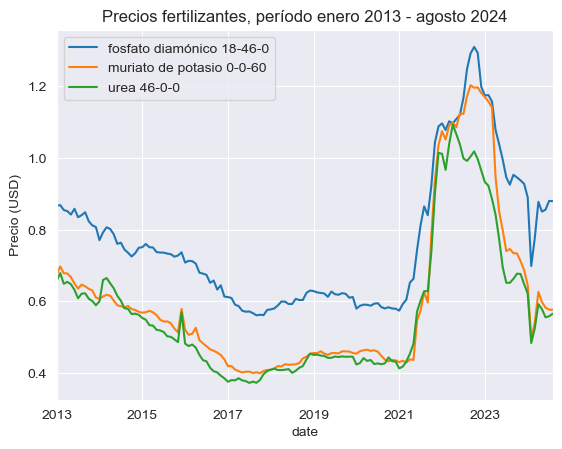

In [65]:
precios_fertilizantes.plot()
plt.title(f"Precios fertilizantes, período {primer_mes_análisis_imprimir} - {último_mes_análisis_imprimir}")
plt.ylabel("Precio (USD)")
plt.show()

### Gas natural y crudo Brent Europa

In [66]:
# Importar datos de CMO:
precio_commodities_Europa = pd.read_excel(
    'data\CMO-Historical-Data-Monthly.xlsx',
    skiprows=4,
    sheet_name='Monthly Prices',
    header=None
    )

# Fusionar la primera fila con la segunda para crear nombres de columnas:
precio_commodities_Europa.loc[0] = precio_commodities_Europa.loc[0].fillna('') + ' ' + precio_commodities_Europa.loc[1].fillna('')

# Formatear primera fila:
precio_commodities_Europa.loc[0] = precio_commodities_Europa.loc[0]\
    .apply(preprocess_text, keep_characters='$/')\
    .str.replace(' ', '_')\
    .str.replace('$/', 'usd_per_')\

# Establecer primera fila como nombres de columnas:
precio_commodities_Europa.columns = precio_commodities_Europa.loc[0]

# Filtrar filas y columnas útiles:
precio_commodities_Europa = precio_commodities_Europa[
    ['date', 'crude_oil_brent_usd_per_bbl', 'natural_gas_europe_usd_per_mmbtu']
    ]\
        .drop([0, 1])

# Formatear correctamente la columna de fechas:
precio_commodities_Europa['date'] = pd.to_datetime(
    precio_commodities_Europa['date']\
        .str.replace('M', '-')\
        + '-01'
    ) + pd.offsets.MonthEnd(0)

# Establecer columna de fechas como índice y filtrar años de análisis:
precio_commodities_Europa = precio_commodities_Europa\
    .set_index('date')\
        [primer_mes_análisis:último_mes_análisis]

# Convertir columnas de crudo y gas a formato numérico correcto:
for col in ['crude_oil_brent_usd_per_bbl', 'natural_gas_europe_usd_per_mmbtu']:
    precio_commodities_Europa[col] = precio_commodities_Europa[col].astype(float)

precio_commodities_Europa.columns.name = None

precio_commodities_Europa.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 140 entries, 2013-01-31 to 2024-08-31
Data columns (total 2 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   crude_oil_brent_usd_per_bbl       140 non-null    float64
 1   natural_gas_europe_usd_per_mmbtu  140 non-null    float64
dtypes: float64(2)
memory usage: 3.3 KB


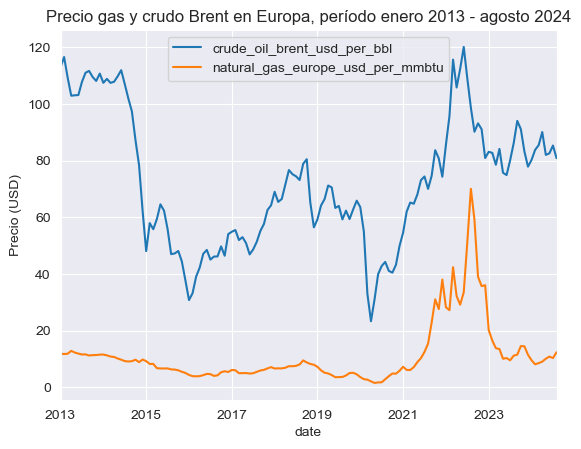

In [67]:
precio_commodities_Europa.plot()
plt.title(f"Precio gas y crudo Brent en Europa, período {primer_mes_análisis_imprimir} - {último_mes_análisis_imprimir}")
plt.ylabel("Precio (USD)")
plt.show()

In [68]:
np.corrcoef(precios_fertilizantes['urea 46-0-0'], precio_commodities_Europa['natural_gas_europe_usd_per_mmbtu'])[0,1]

0.8500528831311174

### Inflación

In [69]:
inflación_mensual = pd.read_csv('data\inflación_mensual.csv')

inflación_mensual['Inflación mensual general'] = inflación_mensual['Inflación mensual general'].str.replace(',', '.')

inflación_mensual_nacional = inflación_mensual\
    .rename(columns={
        'Mes': 'date',
        'Inflación mensual general': 'inflación_mensual'
        })\
    .astype({
        'date': 'datetime64[ns]',
        'inflación_mensual': 'float'
        })\
    [inflación_mensual['Región'] == 'NACIONAL']\
    .drop(columns=['Año', 'Región'])#

inflación_mensual_nacional['date'] = pd.to_datetime(inflación_mensual_nacional['date']) + pd.offsets.MonthEnd(0)

inflación_mensual_nacional = inflación_mensual_nacional\
    .set_index('date')\
    [primer_mes_análisis:último_mes_análisis]

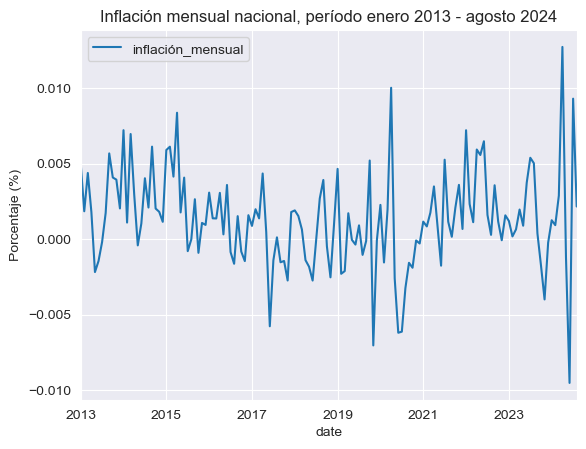

In [70]:
inflación_mensual_nacional.plot()
plt.title(f"Inflación mensual nacional, período {primer_mes_análisis_imprimir} - {último_mes_análisis_imprimir}")
plt.ylabel("Porcentaje (%)")
plt.show()

### Precios combustibles

https://fiduvalor.com.ec/2024/06/24/la-eliminacion-de-subsidios-y-la-evolucion-del-precio-de-la-gasolina-en-ecuador/

In [71]:
# Cargar IPC de combustibles:
ipc_combustibles = pd.read_excel('data\precios-combustibles.xlsx')

# Establecer columna de fechas como índice: 
ipc_combustibles['date'] = pd.to_datetime(ipc_combustibles['date']) + pd.offsets.MonthEnd(0)

# Ordenar dataframe por fecha:
ipc_combustibles = ipc_combustibles\
    .sort_values(by='date')\
    .set_index('date')\
    # [primer_mes_análisis:último_mes_análisis]

# Extraer diesel como el combustible de uso común en transporte de insumos agropecuarios.
ipc_diesel = ipc_combustibles[['diesel']]

In [72]:
# Constantes de precio de combustible diésel extraído de datos de CEPAL:
precio_diesel_2013 = 0.272
precio_diesel_2014 = 0.274 # Año base IPC (INEC 2023)

# Calcular IPC diésel 2013:
ipc_diesel_2013 = round(precio_diesel_2013 / precio_diesel_2014 *100, 6)

# Crear rango de fechas a inferir, meses 2013-2014:
index_inferencias = pd.date_range(start='2013-01', end='2015-01', freq='ME')

# Crear DataFrame de precios de combustibles inferidos:
ipc_combustibles_inferidos = pd.DataFrame()

# Establecer índice de fechas a inferir:
ipc_combustibles_inferidos['date'] = index_inferencias
ipc_combustibles_inferidos.set_index('date', inplace=True)

# Mapear ipc_diesel_2013 para meses de 2013:
condición_año_2013 = (ipc_combustibles_inferidos.index.year == 2013)
ipc_combustibles_inferidos.loc[condición_año_2013, 'diesel'] = ipc_diesel_2013

# Completar IPC de año 2014 (año base):
ipc_combustibles_inferidos = ipc_combustibles_inferidos.fillna(100)

# Unir datos inferidos con los originales:
ipc_diesel_imp = pd.concat(
    [ipc_combustibles_inferidos, ipc_diesel],
    axis=0
    )

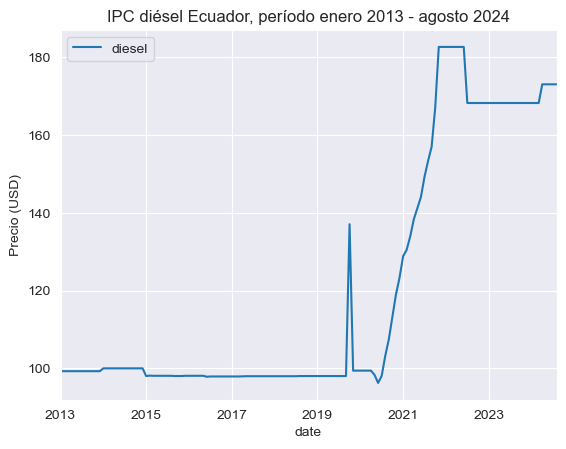

In [73]:
# Graficar precios de combustibles:
ipc_diesel_imp.plot()
plt.title(f"IPC diésel Ecuador, período {primer_mes_análisis_imprimir} - {último_mes_análisis_imprimir}")
plt.ylabel("Precio (USD)")
plt.show()

### Precios WTI

In [112]:
precios_históricos_wti = pd.read_excel('data\Cushing_OK_WTI_Spot_Price_FOB.xlsx')

# Convertir las columnas a formato largo (melt)
precios_históricos_wti = precios_históricos_wti.melt(
    id_vars=["Year"],
    var_name="Month",
    value_name="precio_wti"
    )

# Crear la columna 'date' a partir de 'Year' y 'Month'
precios_históricos_wti['date'] = pd.to_datetime(
    precios_históricos_wti['Year'].astype(str) + '-' + precios_históricos_wti['Month'].str.lower() + '-01',
    format='mixed'
    ) + pd.offsets.MonthEnd(0)

# Ordenar por fecha y filtrar variables útiles:
precios_históricos_wti = precios_históricos_wti\
    .sort_values('date')\
        [['date', 'precio_wti']]\
            .set_index('date')
        

# Ordenar por 'date' y establecer como índice; filtrar por período de análisis:
precios_wti = precios_históricos_wti[primer_mes_análisis:último_mes_análisis]

precios_wti.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 140 entries, 2013-01-31 to 2024-08-31
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   precio_wti  140 non-null    float64
dtypes: float64(1)
memory usage: 2.2 KB


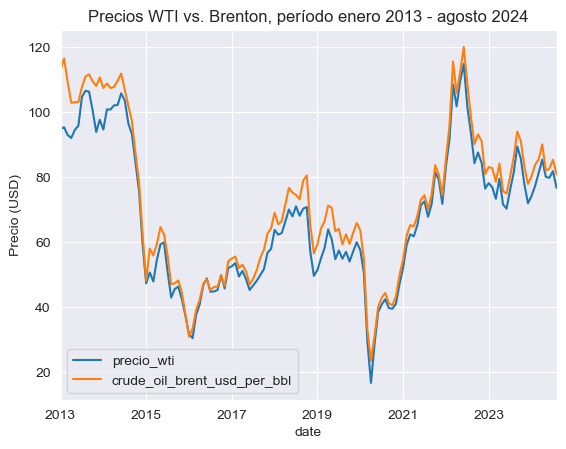

In [115]:
precios_wti.plot()
precio_commodities_Europa['crude_oil_brent_usd_per_bbl'].plot()
plt.title(f"Precio WTI vs. Brenton, período {primer_mes_análisis_imprimir} - {último_mes_análisis_imprimir}")
plt.ylabel("Precio (USD)")
plt.legend()
plt.show()

In [120]:
# Correlación precio de crudo Brenton versus WTI, período:
precio_commodities_Europa['crude_oil_brent_usd_per_bbl'].corr(precios_wti['precio_wti'])

0.9913363529140942

### Datos climáticos

In [138]:
archivo_cckp = 'data\era5-x0.25_timeseries_pr,tas_timeseries_monthly_1950-2022_mean_historical_era5_x0.25_mean.xlsx'
hojas_excel = ['pr', 'tas']
dict_datos_climáticos_histórico = {}

for hoja in hojas_excel:
    dict_datos_climáticos_histórico[hoja] = pd.read_excel(archivo_cckp, sheet_name=hoja)\
        .drop(columns=['code', 'name'])\
        .T\
        .reset_index()
    
    dict_datos_climáticos_histórico[hoja].columns = ['date', hoja]
    
datos_climáticos_histórico = pd.merge(
    dict_datos_climáticos_histórico['pr'],
    dict_datos_climáticos_histórico['tas'],
    on='date',
    how='inner'
    )\
        .rename(columns={'pr': 'precipitación_media_mm', 'tas':'temp_media_Celsius'})

datos_climáticos_histórico['date'] = pd.to_datetime(datos_climáticos_histórico['date'] + '-01') + pd.offsets.MonthEnd(0)

datos_climáticos_histórico.set_index('date', inplace=True)

datos_climáticos_histórico.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 876 entries, 1950-01-31 to 2022-12-31
Data columns (total 2 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   precipitación_media_mm  876 non-null    float64
 1   temp_media_Celsius      876 non-null    float64
dtypes: float64(2)
memory usage: 20.5 KB


array([<Axes: xlabel='date'>, <Axes: xlabel='date'>], dtype=object)

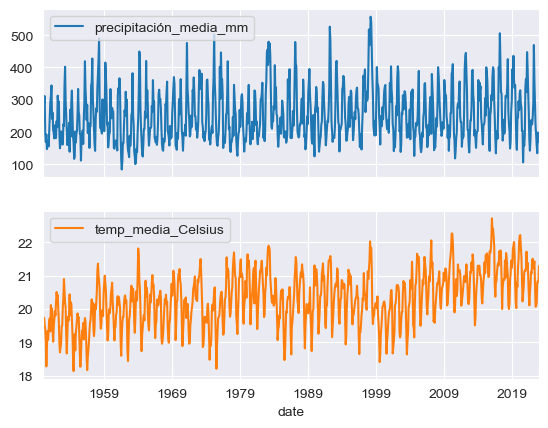

In [139]:
datos_climáticos_histórico.plot(subplots=True)


array([<Axes: xlabel='date'>, <Axes: xlabel='date'>], dtype=object)

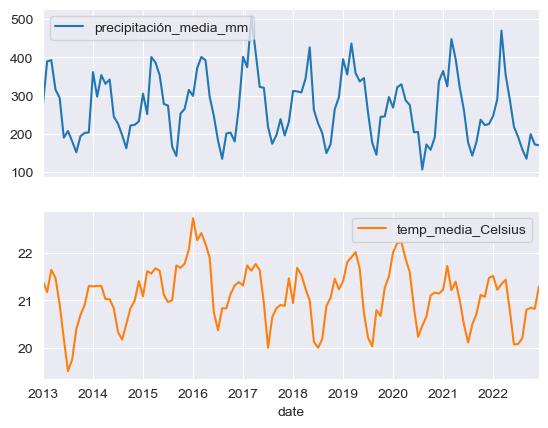

In [140]:
datos_climáticos = datos_climáticos_histórico[primer_mes_análisis:último_mes_análisis]

datos_climáticos.plot(subplots=True)

#### Imputación provisional de datos climáticos para 2023

In [141]:
datos_climáticos_histórico['Mes'] = datos_climáticos_histórico.index.month

rango_meses_2023 = pd.date_range(start='2023-01', end='2024-01', freq='ME')

medias_mensuales_clima = datos_climáticos_histórico\
    .groupby('Mes')\
    [['precipitación_media_mm', 'temp_media_Celsius']]\
    .mean()\
    .reset_index()\
    .drop(columns = ['Mes'])\
    .set_index(rango_meses_2023)

medias_mensuales_clima

precipitación_media_mm  temp_media_Celsius
2023-01-31              287.284521           20.770548
2023-02-28              315.847123           20.869726
2023-03-31              367.957808           20.914932
2023-04-30              346.807397           20.856027
2023-05-31              294.993973           20.534384
2023-06-30              230.550685           19.792329
2023-07-31              198.784247           19.323699
2023-08-31              164.710274           19.580000
2023-09-30              177.460274           19.953425
2023-10-31              205.478630           20.231781
2023-11-30              208.520822           20.382055
2023-12-31              240.887808           20.621096

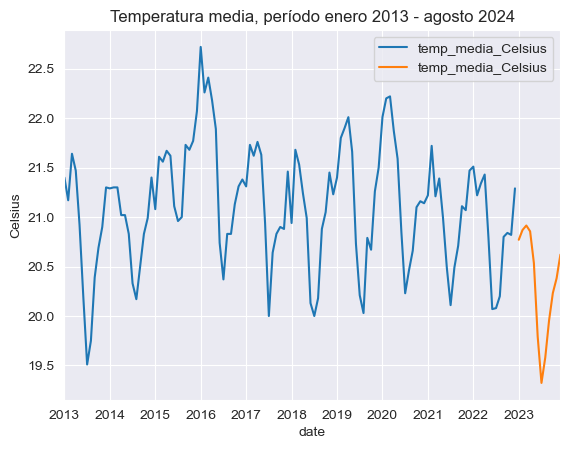

In [155]:
# Graficar temperatura media:
datos_climáticos['temp_media_Celsius'].plot()
medias_mensuales_clima['temp_media_Celsius'].plot()
plt.title(f"Temperatura media, período {primer_mes_análisis_imprimir} - {último_mes_análisis_imprimir}")
plt.ylabel("Celsius")
plt.legend()

plt.show()

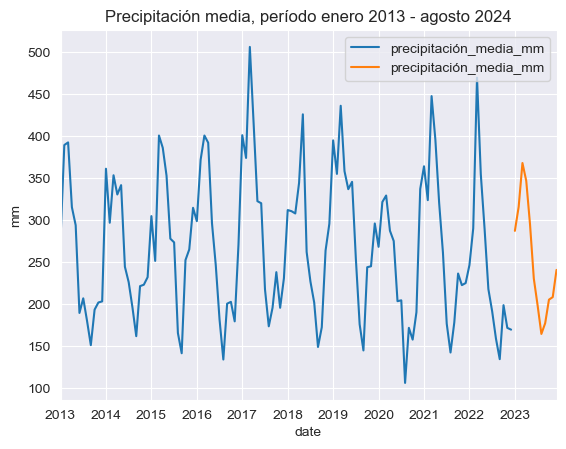

In [157]:
# Graficar precipitaciones:
datos_climáticos['precipitación_media_mm'].plot()
medias_mensuales_clima['precipitación_media_mm'].plot()
plt.title(f"Precipitación media, período {primer_mes_análisis_imprimir} - {último_mes_análisis_imprimir}")
plt.ylabel("mm")
plt.legend()

plt.show()
plt.show()

In [159]:
datos_climáticos_bm_imp = pd.concat([datos_climáticos_histórico, medias_mensuales_clima], axis=0)\
    .drop(columns=['Mes'])

#### Datos SIPA

In [169]:
# Datos de temperatura y precipitaciones SIPA:
datos_climáticos_histórico_sipa = pd.read_excel(r'data\temperatura-precipitacion-sipa-2024.xls', sheet_name='Temperatura y Precipitación', skiprows=7)

In [170]:
# Agregar datos para obtener valores medios nacionales:
datos_climáticos_histórico_sipa = datos_climáticos_histórico_sipa\
    .rename(columns={'Precipitación (mm)': 'precipitación_media_mm', 'Temperatura promedio (°C)':'temp_media_Celsius'})\
    .groupby(['Año', 'Mes'])\
    [['precipitación_media_mm', 'temp_media_Celsius']]\
    .mean()\
    .reset_index()

In [171]:
# Diccionario para mapear meses por sus equivalentes numéricos:
meses = {
    'Enero': '01',
    'Febrero': '02',
    'Marzo': '03',
    'Abril': '04',
    'Mayo': '05',
    'Junio': '06',
    'Julio': '07',
    'Agosto': '08',
    'Septiembre': '09',
    'Octubre': '10',
    'Noviembre': '11',
    'Diciembre': '12'
    }

# Crear la columna de fecha combinando 'Año' y 'Mes':
datos_climáticos_histórico_sipa['date'] = pd.to_datetime(
    datos_climáticos_histórico_sipa['Año'].astype(str) + \
    '-' + \
    datos_climáticos_histórico_sipa['Mes'].map(meses)
    ) + pd.offsets.MonthEnd(0)  # Ajusta al último día del mes

datos_climáticos_histórico_sipa = datos_climáticos_histórico_sipa\
    .sort_values(by='date')\
    .set_index('date')\
    .drop(columns=['Año', 'Mes'])\
    [primer_mes_análisis:]

Correlación precipitación_media_mm:  0.8997581228437685
Correlación temp_media_Celsius:  0.4648387155413048


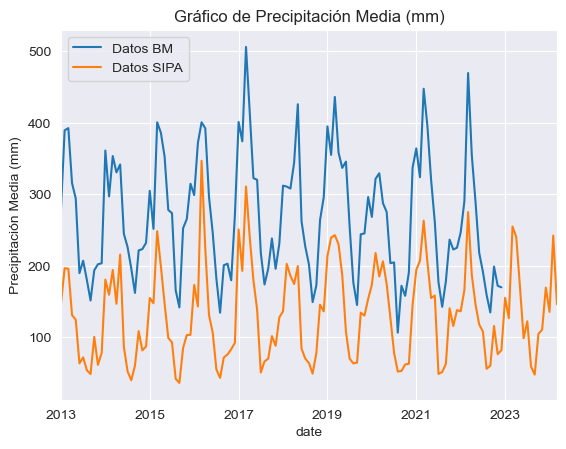

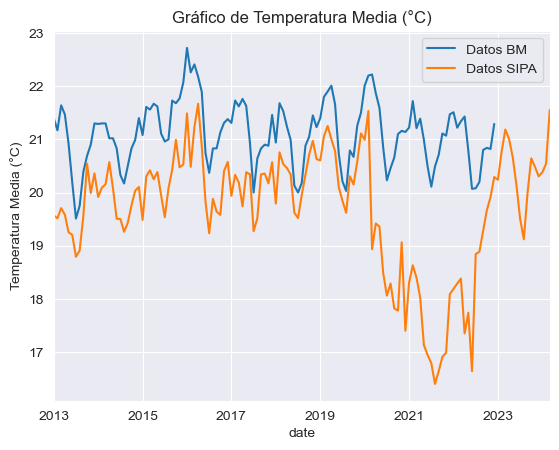

In [172]:
# Revisamos correlaciones entre fuentes de datos distintas:
for col in ('precipitación_media_mm', 'temp_media_Celsius'):
    print(f"Correlación {col}: ", datos_climáticos_histórico[col].corr(datos_climáticos_histórico_sipa[col][:'2022']))

# Gráfica para precipitación_media_mm
datos_climáticos['precipitación_media_mm'].plot(label='Datos BM')
datos_climáticos_histórico_sipa['precipitación_media_mm'].plot(label='Datos SIPA')
plt.legend()
plt.title('Gráfico de Precipitación Media (mm)')
plt.xlabel('date')
plt.ylabel('Precipitación Media (mm)')
plt.show()

# Gráfica para temp_media_Celsius
datos_climáticos['temp_media_Celsius'].plot(label='Datos BM')
datos_climáticos_histórico_sipa['temp_media_Celsius'].plot(label='Datos SIPA')
plt.legend()
plt.title('Gráfico de Temperatura Media (°C)')
plt.xlabel('date')
plt.ylabel('Temperatura Media (°C)')
plt.show()


### Importaciones de Insumos Agrícolas

In [173]:
insumos_agrícolas = pd.read_excel('data\importaciones_cif_por_uso.xlsx', sheet_name='insumos_agrícolas')

In [174]:
insumos_agrícolas['date'] = pd.to_datetime(
    insumos_agrícolas['Año'].astype(str) +\
    '-' + \
    insumos_agrícolas['Num Mes'].astype(str)
    ) + pd.offsets.MonthEnd(0)

insumos_agrícolas['Código Matricero'] = insumos_agrícolas['Código Matricero'].astype(str)

insumos_agrícolas = insumos_agrícolas\
    .set_index('date')\
    .drop(columns=['Año', 'Num Mes'])\
    .rename(columns={
        'Valor CIF dólar en miles': 'cif_miles_usd',
        'Matricero': 'matricero_insumos_agrícolas'
        })\
            [primer_mes_análisis:último_mes_análisis]
    

c:\condaenvs\dsenv\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\condaenvs\dsenv\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\condaenvs\dsenv\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\condaenvs\dsenv\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in

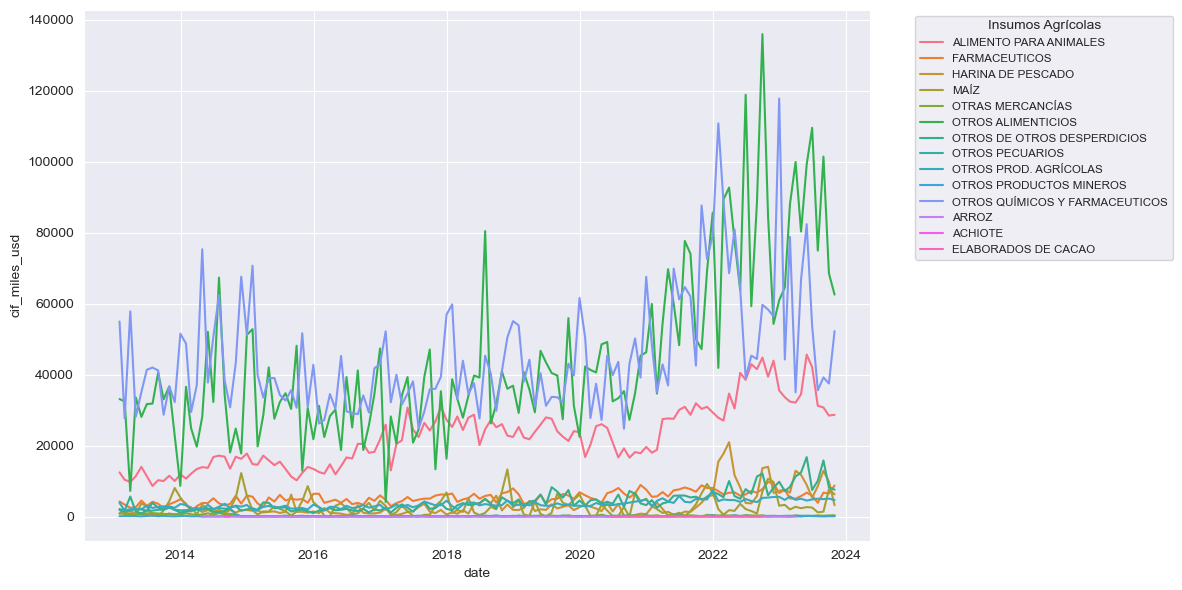

In [175]:
# Crear el gráfico
plt.figure(figsize=(12, 6))
sns.lineplot(x='date', y='cif_miles_usd', data=insumos_agrícolas.reset_index(), hue='matricero_insumos_agrícolas')
plt.legend(title='Insumos Agrícolas', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.tight_layout()
plt.show()

In [176]:
# Crear el DataFrame de insumos como variables, con tabla pivote:
X_insumos = insumos_agrícolas.pivot_table(
    values='cif_miles_usd', 
    index='date', 
    columns='matricero_insumos_agrícolas', 
    aggfunc='sum',
    fill_value=0
    )

c:\condaenvs\dsenv\lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


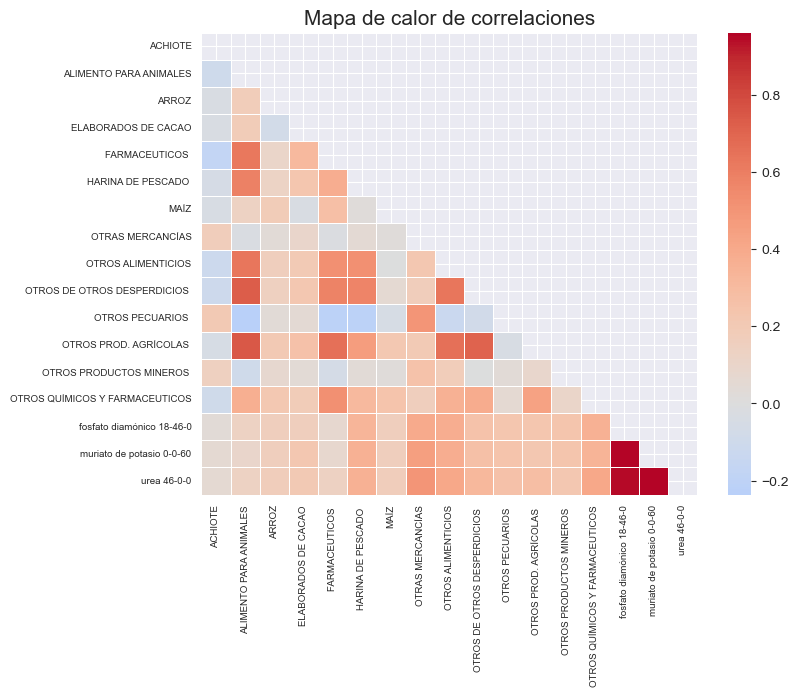

In [177]:
# Unir los DataFrames de insumos y fertilizantes por índice (fechas):
insumos_agrícolas_y_fertilizantes = X_insumos.merge(precios_fertilizantes, left_index=True, right_index=True, how='left')

# Graficar mapa de calor de correlaciones no lineales:
corr = insumos_agrícolas_y_fertilizantes.corr(method="spearman")
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(8, 6))
sns.heatmap(data=corr, mask=mask, cmap='coolwarm', center=0, linewidths=0.5, annot=True, annot_kws={"size": 6})
plt.title('Mapa de calor de correlaciones', size=15)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.show()


In [179]:
import statsmodels.api as sm

# Obtener las variables características regularizadas con una constante:
const_X = sm.add_constant(X_insumos)

target_var = 'urea 46-0-0'

y = insumos_agrícolas_y_fertilizantes[target_var].to_frame()

# Ajustamos una regresión OLS robusta con HC1 para posibles valores atípicos:
model = sm.OLS(y, const_X).fit(cov_type='HC3')
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            urea 46-0-0   R-squared:                       0.734
Model:                            OLS   Adj. R-squared:                  0.701
Method:                 Least Squares   F-statistic:                     17.76
Date:               ju., 10 oct. 2024   Prob (F-statistic):           1.35e-22
Time:                        11:38:40   Log-Likelihood:                 115.59
No. Observations:                 130   AIC:                            -201.2
Df Residuals:                     115   BIC:                            -158.2
Df Model:                          14                                         
Covariance Type:                  HC3                                         
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

In [180]:
from sklearn.preprocessing import RobustScaler

# Escalar datos:
X_scaler = RobustScaler()
X_insumos_escalado = X_scaler.fit_transform(X_insumos)

y_scaler = RobustScaler()
y_escalado = y_scaler.fit_transform(y)

# Definir el tamaño del conjunto de entrenamiento
train_size = int(len(X_insumos_escalado) * 0.8)

# Dividir los datos
X_train, X_test = X_insumos_escalado[:train_size], X_insumos_escalado[train_size:]
y_train, y_test = y_escalado[:train_size], y_escalado[train_size:]

In [181]:
from sklearn.linear_model import Lasso, LassoCV
from sklearn.metrics import mean_squared_error

# Definimos una lista de alphas para probar
alphas = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]

# Creamos el modelo LassoCV
lasso_cv = LassoCV(alphas=alphas, cv=5, max_iter=5000)

# Ajustamos el modelo LassoCV a los datos escalados
lasso_cv.fit(X_train, y_train.ravel())

# Obtenemos el alpha óptimo para Lasso
optimal_alpha_lasso = lasso_cv.alpha_
print("Alpha óptimo para Lasso:", optimal_alpha_lasso)

# Ajustar el modelo Lasso con el alpha óptimo
lasso_opt = Lasso(alpha=optimal_alpha_lasso)
lasso_opt.fit(X_insumos_escalado, y_escalado)

# Predecimos con el modelo Lasso:
lasso_predictions = lasso_opt.predict(X_test)
lasso_mse = mean_squared_error(y_test, lasso_predictions)
print("MSE Lasso: ", lasso_mse)


Alpha óptimo para Lasso: 0.001
MSE Lasso:  0.5080945219811592


In [182]:
from sklearn.linear_model import Ridge, RidgeCV

# Creamos el modelo RidgeCV
ridge_cv = RidgeCV(alphas=alphas, cv=5)

# Ajustamos el modelo RidgeCV a los datos escalados
ridge_cv.fit(X_train, y_train)

# Obtenemos el alpha óptimo para Ridge
optimal_alpha_ridge = ridge_cv.alpha_
print("Alpha óptimo para Ridge:", optimal_alpha_ridge)

# Ajustamos el modelo Ridge con el alpha óptimo
ridge_opt = Ridge(alpha=optimal_alpha_ridge)
ridge_opt.fit(X_insumos_escalado, y_escalado)

# Predecimos con el modelo Ridge:
ridge_predictions = ridge_opt.predict(X_test)
ridge_mse = mean_squared_error(y_test, ridge_predictions)
print("MSE Ridge: ", ridge_mse)

Alpha óptimo para Ridge: 10.0
MSE Ridge:  0.5366202704124261


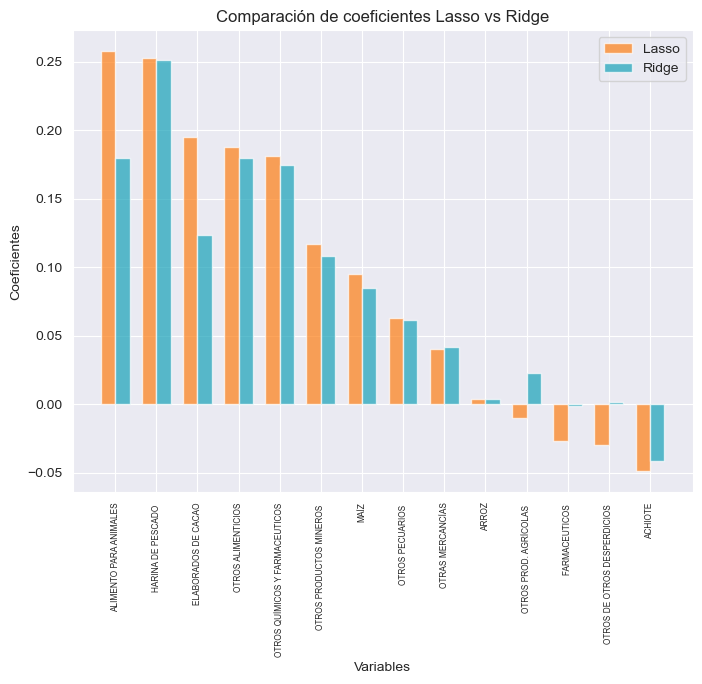

In [183]:
# Creamos un DataFrame con los coeficientes Lasso y Ridge:
regularization_coefs = pd.DataFrame(
    {'X': X_insumos.columns, 
    'lasso_coefs': lasso_opt.coef_.flatten(),
    'ridge_coefs': ridge_opt.coef_.flatten()}
    )

# Ordenamos el DataFrame según los coeficientes de Lasso (o Ridge) en orden descendente:
regularization_coefs = regularization_coefs.sort_values(by=['lasso_coefs', 'ridge_coefs'], ascending=[False, False])

# Creamos un gráfico de barras comparativo:
bar_width = 0.35
index = np.arange(len(regularization_coefs['X']))

fig, ax = plt.subplots(figsize=(8, 6))
bar1 = ax.bar(index, regularization_coefs['lasso_coefs'], bar_width, label='Lasso', color='#fd7e14', alpha=0.7)
bar2 = ax.bar(index + bar_width, regularization_coefs['ridge_coefs'], bar_width, label='Ridge', color='#17a2b8', alpha=0.7)

ax.set_xlabel('Variables')
ax.set_ylabel('Coeficientes')
ax.set_title('Comparación de coeficientes Lasso vs Ridge')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(regularization_coefs['X'], rotation=90, fontsize=6)
ax.legend()
plt.show()

### Exportaciones

In [184]:
exportaciones = pd.read_excel(
    r'data\exportaciones_fob.xlsx',
    sheet_name='Mensual',
    usecols=['Año', 'Num Mes', 'Matricero', 'Valor FOB Dólar en miles']
    )

In [185]:
exportaciones['date'] = pd.to_datetime(
    exportaciones['Año'].astype(str) +\
    '-' + \
    exportaciones['Num Mes'].astype(str)
    ) + pd.offsets.MonthEnd(0)

exportaciones = exportaciones\
    .set_index('date')\
    .drop(columns=['Año', 'Num Mes'])\
    .rename(columns={
        'Valor FOB Dólar en miles': 'fob_miles_usd',
        'Matricero': 'matricero_exportaciones'})\
    [primer_mes_análisis:último_mes_análisis]

In [186]:
lista_exportaciones_relevantes = sorted(
    ['PRODUCTOS AGRICOLAS EN CONSERVA ', 'OTRAS FIBRAS VEGETALES', 'CARNE, LECHE Y ELABORADOS ', 'PIÑAS ',
    'HOJAS DE TÉ ', 'MELONES ', 'OTROS PROD. AGRÍCOLAS ', 'OTRAS FRUTAS', 'TABACO EN RAMA',
    'OTROS ALIMENTICIOS', 'JUGOS Y CONSERVAS DE FRUTAS ', 'EXTRACTOS Y ACEITES VEGETALES ',
    'ABACÁ ', 'HARINA Y ELABORADOS DE CEREALES ', 'OTROS QUÍMICOS Y FARMACEUTICOS', 'FLORES NATURALES',
    'CAFÉ INDUSTRIALIZADO', 'HARINA DE PESCADO ', 'CAFÉ LAVADO ', 'ELABORADOS DE CACAO ', 'CACAO ',
    'PLÁTANO ', 'ELABORADOS DE BANANO',  'ALIMENTO PARA ANIMALES', 'ALGODÓN ', 'AZÚCAR', 'MAÍZ', 'ARROZ ',
    'MELAZAS Y PANELAS ', 'NARANJAS', 'BANANO', 'CONÍFERAS ', 'ACHIOTE ', 'CAFE NATURAL']
    )

exportaciones_relevantes = exportaciones[exportaciones['matricero_exportaciones'].isin(lista_exportaciones_relevantes)]

In [187]:
# Crear el DataFrame de insumos como variables, con tabla pivote:
X_exportaciones = exportaciones_relevantes.pivot_table(
    values='fob_miles_usd', 
    index='date', 
    columns='matricero_exportaciones', 
    aggfunc='sum',
    fill_value=0
    )

c:\condaenvs\dsenv\lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


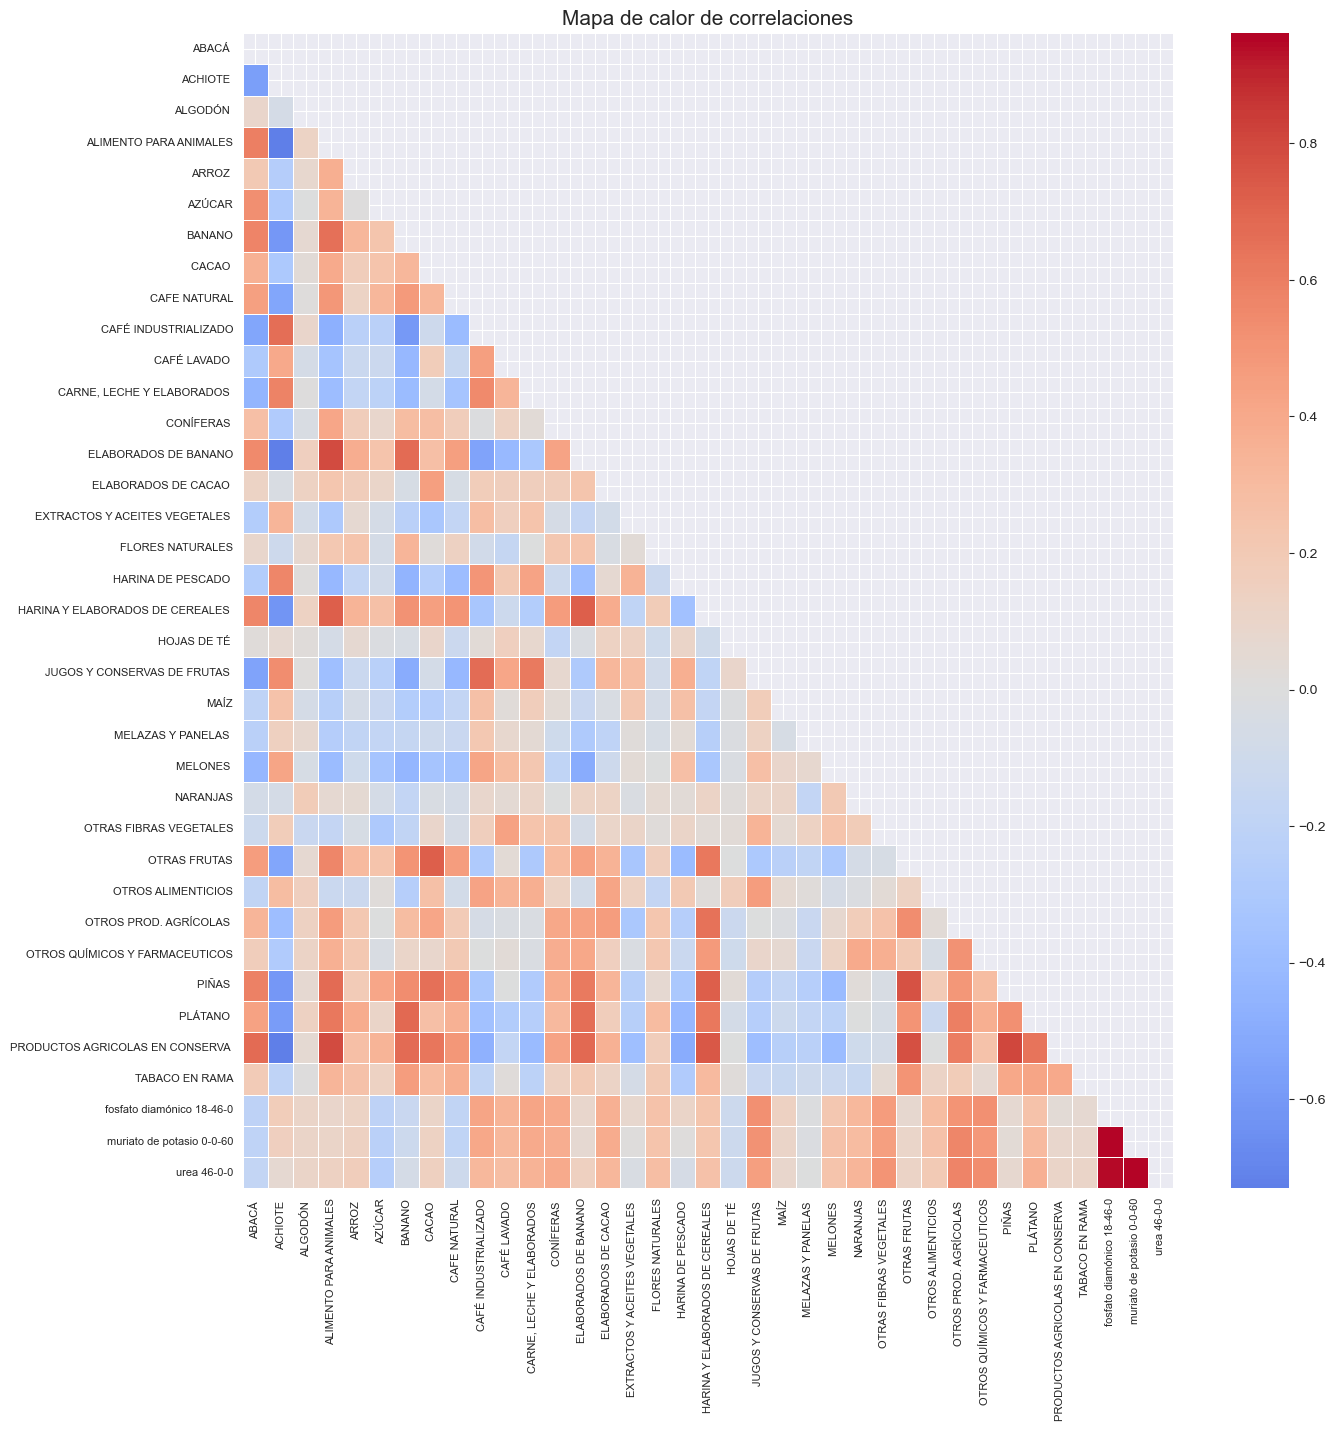

In [188]:
# Unir los DataFrames de insumos y fertilizantes por índice (fechas):
exportaciones_y_fertilizantes = X_exportaciones.merge(precios_fertilizantes, left_index=True, right_index=True, how='left')

# Graficar mapa de calor de correlaciones no lineales:
corr = exportaciones_y_fertilizantes.corr(method="spearman")
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(15, 15))
sns.heatmap(data=corr, mask=mask, cmap='coolwarm', center=0, linewidths=0.5, annot=True, annot_kws={"size": 5})
plt.title('Mapa de calor de correlaciones', size=15)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.show()

In [189]:
from sklearn.preprocessing import RobustScaler

# Escalar datos:
X_scaler = RobustScaler()
X_exportaciones_escalado = X_scaler.fit_transform(X_exportaciones)

y_scaler = RobustScaler()
y_escalado = y_scaler.fit_transform(y)

# Definir el tamaño del conjunto de entrenamiento
train_size = int(len(X_exportaciones_escalado) * 0.8)

# Dividir los datos
X_train, X_test = X_exportaciones_escalado[:train_size], X_exportaciones_escalado[train_size:]
y_train, y_test = y_escalado[:train_size], y_escalado[train_size:]

In [190]:
from sklearn.linear_model import Lasso, LassoCV
from sklearn.metrics import mean_squared_error

# Definimos una lista de alphas para probar
alphas = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]

# Creamos el modelo LassoCV
lasso_cv = LassoCV(alphas=alphas, cv=5, max_iter=5000)

# Ajustamos el modelo LassoCV a los datos escalados
lasso_cv.fit(X_train, y_train.ravel())

# Obtenemos el alpha óptimo para Lasso
optimal_alpha_lasso = lasso_cv.alpha_
print("Alpha óptimo para Lasso:", optimal_alpha_lasso)

# Ajustar el modelo Lasso con el alpha óptimo
lasso_opt = Lasso(alpha=optimal_alpha_lasso)
lasso_opt.fit(X_exportaciones_escalado, y_escalado)

# Predecimos con el modelo Lasso:
lasso_predictions = lasso_opt.predict(X_test)
lasso_mse = mean_squared_error(y_test, lasso_predictions)
print("MSE Lasso: ", lasso_mse)

Alpha óptimo para Lasso: 0.01
MSE Lasso:  0.27554732231824713


In [191]:
from sklearn.linear_model import Ridge, RidgeCV

# Creamos el modelo RidgeCV
ridge_cv = RidgeCV(alphas=alphas, cv=5)

# Ajustamos el modelo RidgeCV a los datos escalados
ridge_cv.fit(X_train, y_train)

# Obtenemos el alpha óptimo para Ridge
optimal_alpha_ridge = ridge_cv.alpha_
print("Alpha óptimo para Ridge:", optimal_alpha_ridge)

# Ajustamos el modelo Ridge con el alpha óptimo
ridge_opt = Ridge(alpha=optimal_alpha_ridge)
ridge_opt.fit(X_exportaciones_escalado, y_escalado)

# Predecimos con el modelo Ridge:
ridge_predictions = ridge_opt.predict(X_test)
ridge_mse = mean_squared_error(y_test, ridge_predictions)
print("MSE Ridge: ", ridge_mse)

Alpha óptimo para Ridge: 1.0
MSE Ridge:  0.24410588446559706


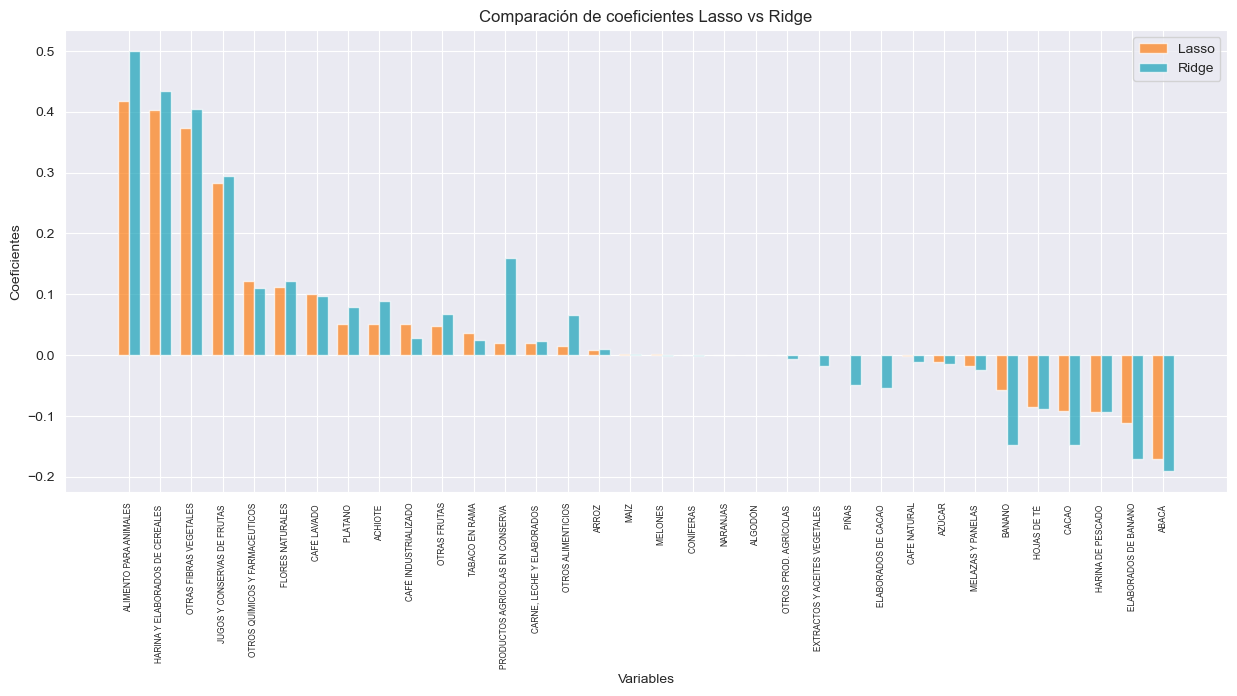

In [192]:
# Creamos un DataFrame con los coeficientes Lasso y Ridge:
regularization_coefs = pd.DataFrame(
    {'X': X_exportaciones.columns, 
    'lasso_coefs': lasso_opt.coef_.flatten(),
    'ridge_coefs': ridge_opt.coef_.flatten()}
    )

# Ordenamos el DataFrame según los coeficientes de Lasso (o Ridge) en orden descendente:
regularization_coefs = regularization_coefs.sort_values(by=['lasso_coefs', 'ridge_coefs'], ascending=[False, False])

# Creamos un gráfico de barras comparativo:
bar_width = 0.35
index = np.arange(len(regularization_coefs['X']))

fig, ax = plt.subplots(figsize=(15, 6))
bar1 = ax.bar(index, regularization_coefs['lasso_coefs'], bar_width, label='Lasso', color='#fd7e14', alpha=0.7)
bar2 = ax.bar(index + bar_width, regularization_coefs['ridge_coefs'], bar_width, label='Ridge', color='#17a2b8', alpha=0.7)

ax.set_xlabel('Variables')
ax.set_ylabel('Coeficientes')
ax.set_title('Comparación de coeficientes Lasso vs Ridge')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(regularization_coefs['X'], rotation=90, fontsize=6)
ax.legend()
plt.show()

### Subsidio urea

Fuente: https://www.agricultura.gob.ec/agricultores-pagaran-el-50-del-costo-comercial-del-saco-de-urea/

In [193]:
index_subsidio = pd.date_range(start='2013-01', end='2024-01', freq='ME')

subsidio_urea = pd.DataFrame(index=index_subsidio, columns=['tiene_subsidio_urea'])
subsidio_urea['tiene_subsidio_urea'] = False

# Meses en los que hay subsidio de urea:
meses_con_subsidio = pd.date_range(start='2022-07', end='2024-01', freq='ME')

# Marca como True los meses en los que hay subsidio de urea
subsidio_urea.loc[meses_con_subsidio, 'tiene_subsidio_urea'] = True

### Unir DataFrames

In [194]:
frames = [precio_commodities_Europa, inflación_mensual_nacional, ipc_combustibles_imp, datos_climáticos_histórico_bm_imp, precios_fertilizantes]

for frame in frames:
    print("Rango de fechas:", frame.index.min(), " a ", frame.index.max())

Rango de fechas: 2013-01-31 00:00:00  a  2024-08-31 00:00:00
Rango de fechas: 2013-01-31 00:00:00  a  2024-08-31 00:00:00
Rango de fechas: 2013-01-31 00:00:00  a  2024-08-31 00:00:00
Rango de fechas: 1950-01-31 00:00:00  a  2023-12-31 00:00:00
Rango de fechas: 2013-01-31 00:00:00  a  2024-08-31 00:00:00


In [195]:
# Unir todas las variables en un solo DataFrame:
df = pd.concat(frames, axis=1)

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 896 entries, 1950-01-31 to 2024-08-31
Freq: ME
Data columns (total 9 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   crude_oil_brent_usd_per_bbl       140 non-null    float64
 1   natural_gas_europe_usd_per_mmbtu  140 non-null    float64
 2   inflación_mensual                 140 non-null    float64
 3   diesel                            140 non-null    float64
 4   precipitación_media_mm            888 non-null    float64
 5   temp_media_Celsius                888 non-null    float64
 6   fosfato diamónico 18-46-0         140 non-null    float64
 7   muriato de potasio 0-0-60         140 non-null    float64
 8   urea 46-0-0                       140 non-null    float64
dtypes: float64(9)
memory usage: 70.0 KB


### Diferenciación no-estacional y estacional

#### Estacionareidad por *Dickey-Fuller* y *Kwiatkowski-Phillips-Schmidt-Shin*

In [196]:
df_test_estacionareidad = fertilizantes_utils.evaluar_estacionareidad(df)

df_test_estacionareidad

NameError: name 'fertilizantes_utils' is not defined

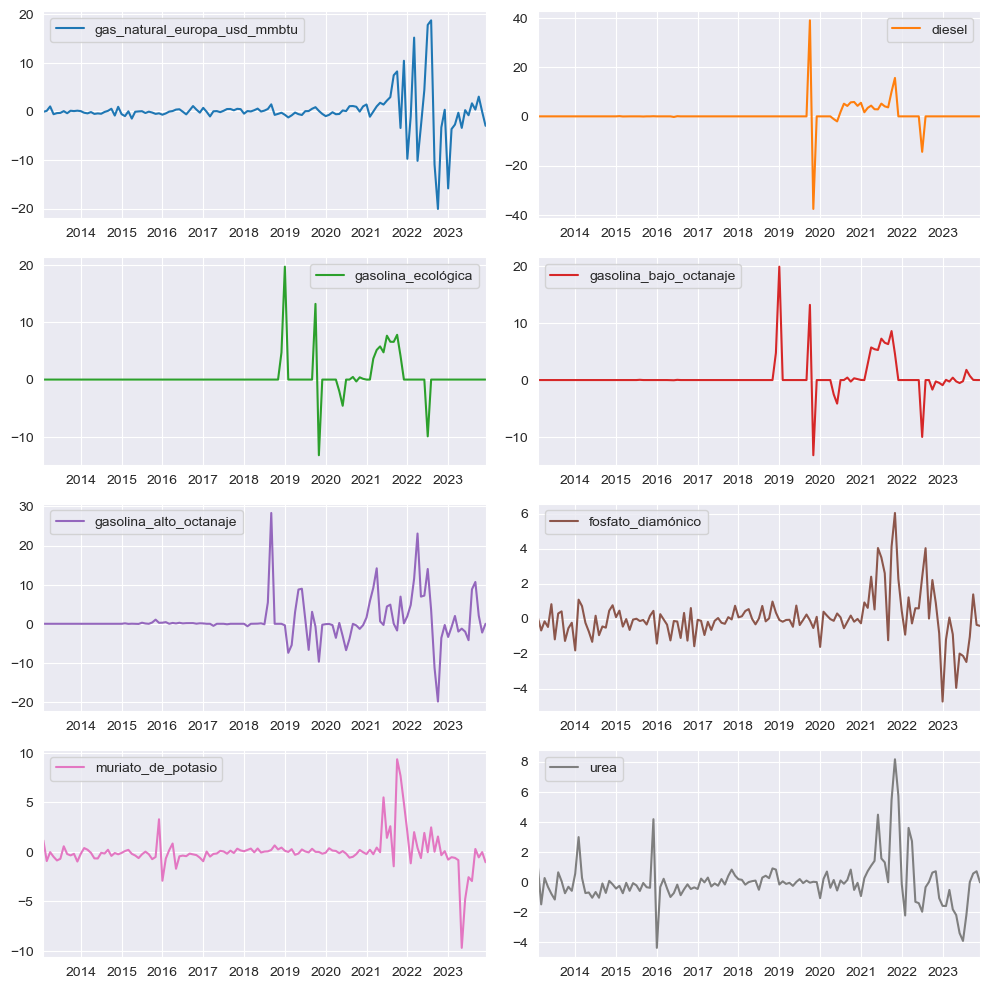

In [59]:
import pmdarima as pm
from pmdarima.arima.utils import ndiffs, nsdiffs

variables_no_estacionarias = df_test_estacionareidad.query("estado_estacionario == 'No estacionario'")['variable'].values

df_no_estacionarias = df[variables_no_estacionarias]

df_diferenciadas = pd.DataFrame(index=pd.date_range(start='2013-02', end='2024-01', freq='ME'))

for col in variables_no_estacionarias:
    
    # Determinar el número de diferenciaciones no estacionales
    d = ndiffs(df_no_estacionarias[col])
    
    df_diferenciadas[col] = np.diff(df_no_estacionarias[col], n=d)

df_diferenciadas.plot(
    subplots=True,
    layout=(int(np.ceil(len(variables_no_estacionarias)/2)), 2),
    figsize=(10, 10),
    sharex=False,
    sharey=False
    )
plt.tight_layout()
plt.show()

In [60]:
df_diferenciadas_test = fertilizantes_utils.evaluar_estacionareidad(df_diferenciadas)

df_diferenciadas_test

variable  valor_p_adfuller  valor_p_kpss  \
0  gas_natural_europa_usd_mmbtu      1.462501e-05           0.1   
1                        diesel      5.463813e-28           0.1   
2            gasolina_ecológica      2.083977e-03           0.1   
3        gasolina_bajo_octanaje      2.145208e-03           0.1   
4        gasolina_alto_octanaje      1.538316e-06           0.1   
5             fosfato_diamónico      7.973434e-02           0.1   
6            muriato_de_potasio      5.080163e-05           0.1   
7                          urea      4.891775e-02           0.1   

   adfuller_rechazar_H0  kpss_rechazar_H0 estado_estacionario  
0                  True             False        Estacionario  
1                  True             False        Estacionario  
2                  True             False        Estacionario  
3                  True             False        Estacionario  
4                  True             False        Estacionario  
5                 False             False            No claro  
6                  True             False        Estacionario  
7                  True             False        Estacionario

In [61]:
variables_originalmente_estacionarias = df[
    df_test_estacionareidad\
    .query("estado_estacionario == 'Estacionario'")\
    ['variable']\
    .values
    ]

variables_exitosamente_diferenciadas = df_diferenciadas[
    df_diferenciadas_test\
    .query("estado_estacionario == 'Estacionario'")\
    ['variable']\
    .values
    ]

df_estacionarias = pd.concat(
    [variables_originalmente_estacionarias,
     variables_exitosamente_diferenciadas],
    axis=1)\
    .dropna()
# df_capped = fertilizantes_utils.apply_outlier_capping()

In [62]:
df_estacionarias

inflación_mensual  precipitación_media_mm  \
2013-02-28           0.001847                 224.920   
2013-03-31           0.004384                 304.430   
2013-04-30           0.001790                 266.910   
2013-05-31          -0.002179                 250.850   
2013-06-30          -0.001448                 125.280   
...                       ...                     ...   
2023-08-31           0.005030                  87.512   
2023-09-30           0.000379                 118.649   
2023-10-31          -0.001750                 150.975   
2023-11-30          -0.003992                 130.995   
2023-12-31          -0.000232                 120.856   

            gas_natural_europa_usd_mmbtu  diesel  gasolina_ecológica  \
2013-02-28                     -0.100000     0.0                 0.0   
2013-03-31                      0.100000     0.0                 0.0   
2013-04-30                      1.010000     0.0                 0.0   
2013-05-31                     -0.590000     0.0                 0.0   
2013-06-30                     -0.370000     0.0                 0.0   
...                                  ...     ...                 ...   
2023-08-31                      1.646661     0.0                 0.0   
2023-09-30                      0.357351     0.0                 0.0   
2023-10-31                      3.020212     0.0                 0.0   
2023-11-30                     -0.084452     0.0                 0.0   
2023-12-31                     -2.978397     0.0                 0.0   

            gasolina_bajo_octanaje  gasolina_alto_octanaje  \
2013-02-28                0.000000                0.000000   
2013-03-31                0.000000                0.000000   
2013-04-30                0.000000                0.000000   
2013-05-31                0.000000                0.000000   
2013-06-30                0.000000                0.000000   
...                            ...                     ...   
2023-08-31                1.785299                8.803571   
2023-09-30                0.742004               10.694397   
2023-10-31                0.025813                2.077961   
2023-11-30                0.000000               -2.238623   
2023-12-31                0.000000                0.000000   

            muriato_de_potasio  urea  
2013-02-28                1.15  1.09  
2013-03-31               -0.94 -1.49  
2013-04-30               -0.04  0.26  
2013-05-31               -0.51 -0.33  
2013-06-30               -0.88 -0.79  
...                        ...   ...  
2023-08-31               -2.96 -2.19  
2023-09-30                0.28 -0.01  
2023-10-31               -0.57  0.56  
2023-11-30               -0.04  0.71  
2023-12-31               -1.06 -0.03  

[131 rows x 9 columns]

In [63]:
def apply_outlier_capping(series, multiplier=1.5):
    """
    Aplica capping a los valores atípicos de una serie.

    Parámetros:
    - series (pd.Series): Serie de entrada.
    - multiplier (float): Multiplicador para el IQR para determinar los límites de capping. Default es 1.5.

    Devuelve:
    - pd.Series: Serie con capping aplicado.
    """
    
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1

    # Definir límites
    upper_limit = Q3 + multiplier * IQR
    lower_limit = Q1 - multiplier * IQR

    # Aplicar capping
    series_capped = series.clip(lower=lower_limit, upper=upper_limit)
    
    return pd.Series(series_capped)

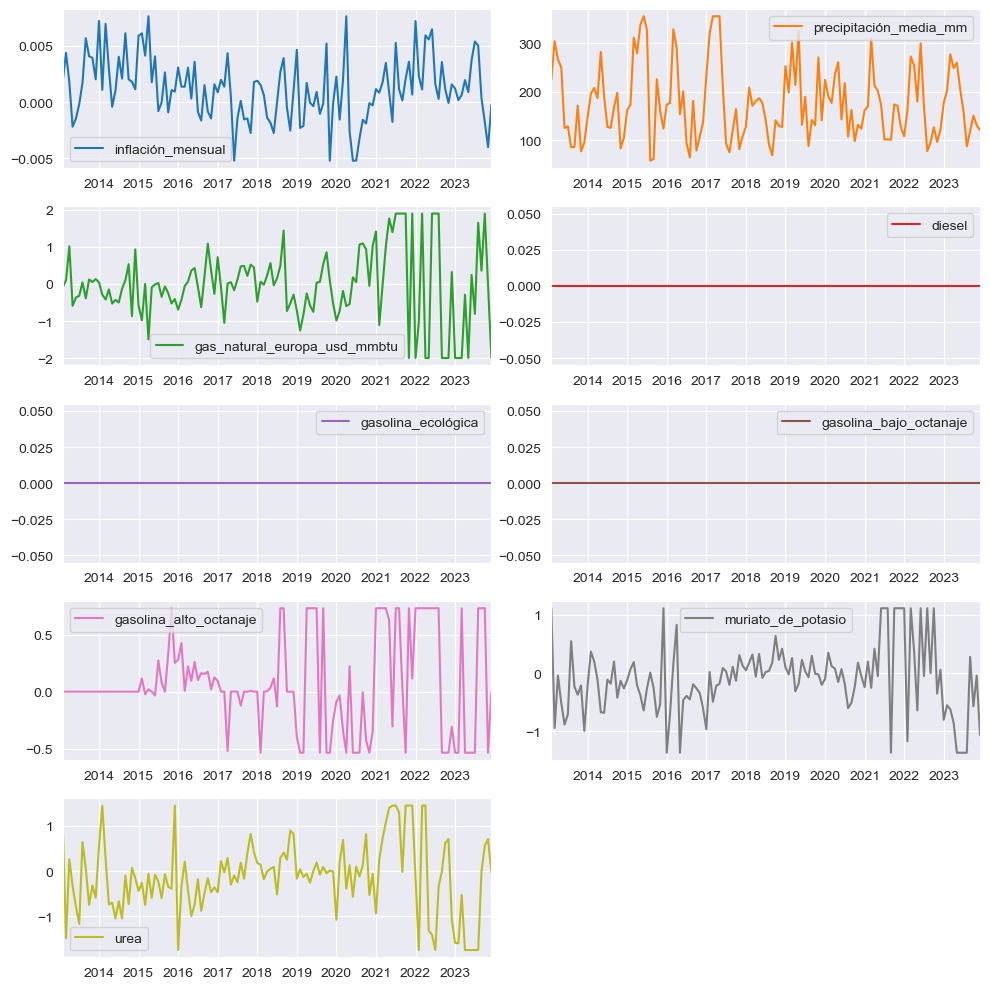

In [64]:

df_capped = pd.DataFrame(index=df_estacionarias.index)

multiplicador = 1.5

for col in df_estacionarias.columns:
    df_capped[col] = apply_outlier_capping(df_estacionarias[col], multiplier=multiplicador)
df_capped.plot(
    subplots=True,
    layout=(int(np.ceil(len(df_capped.columns)/2)), 2),
    figsize=(10, 10),
    sharex=False,
    sharey=False
    )
plt.tight_layout()
plt.show()

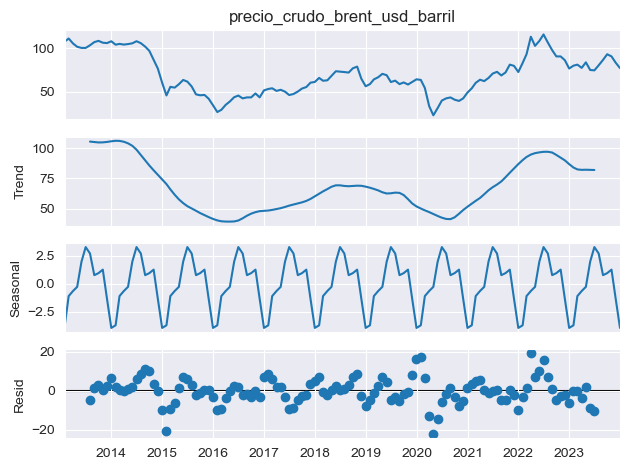

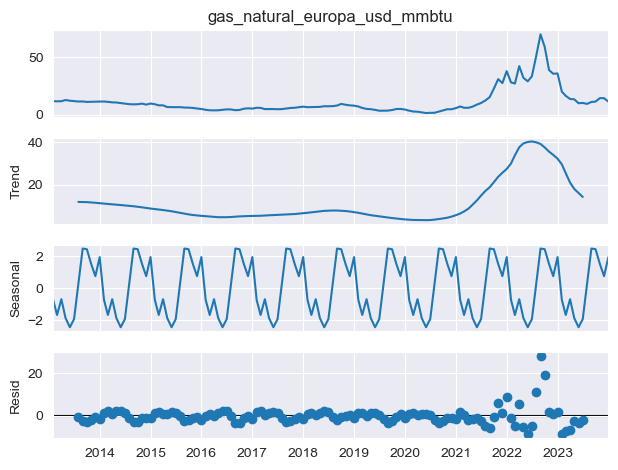

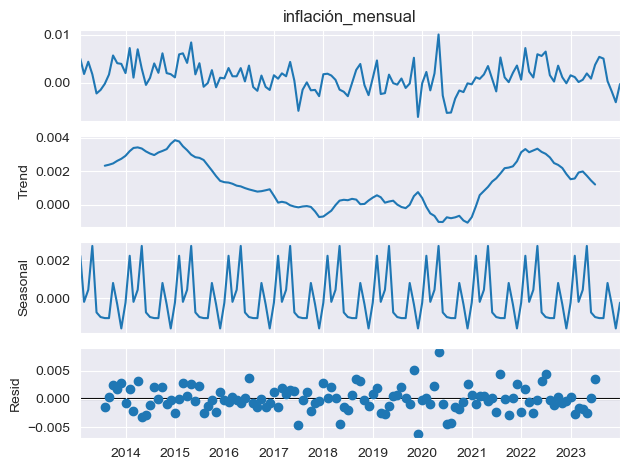

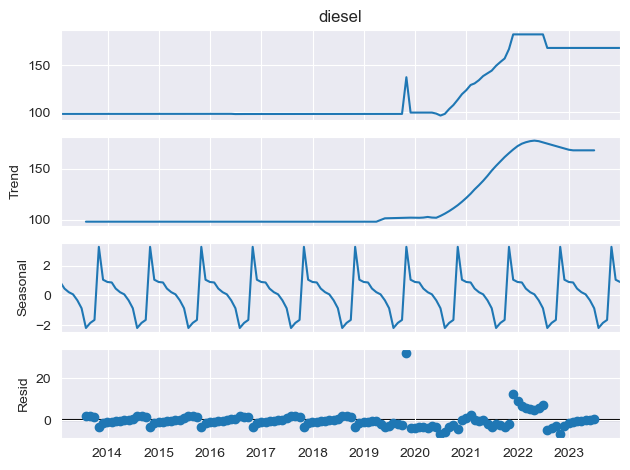

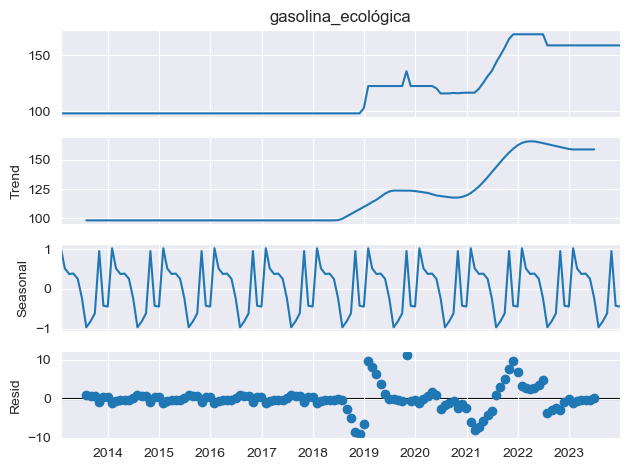

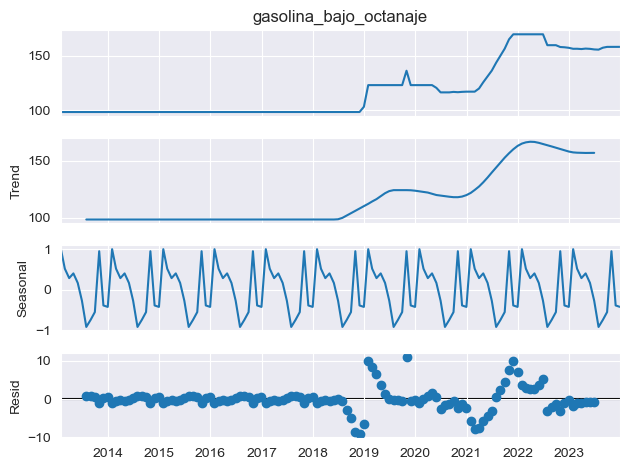

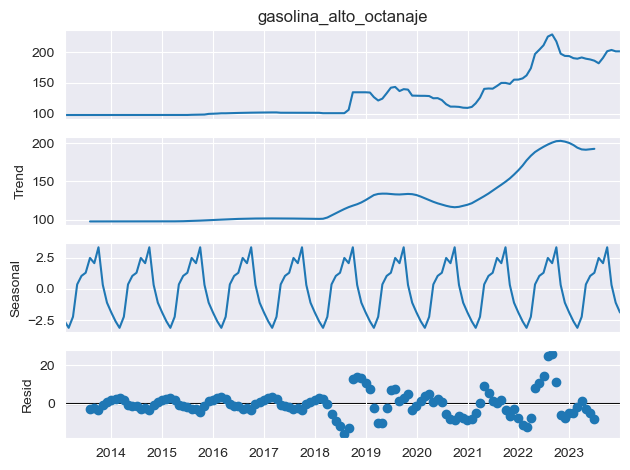

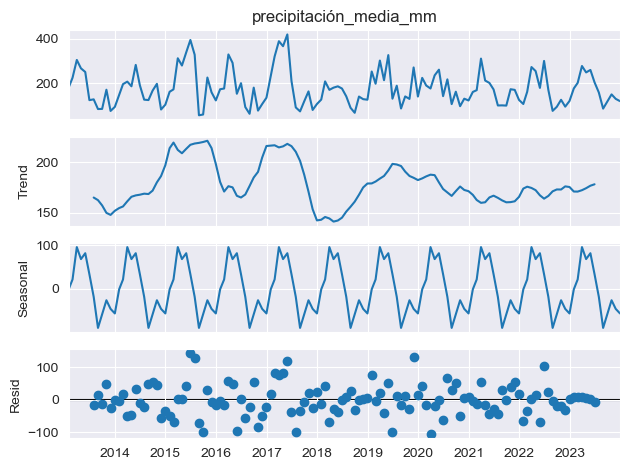

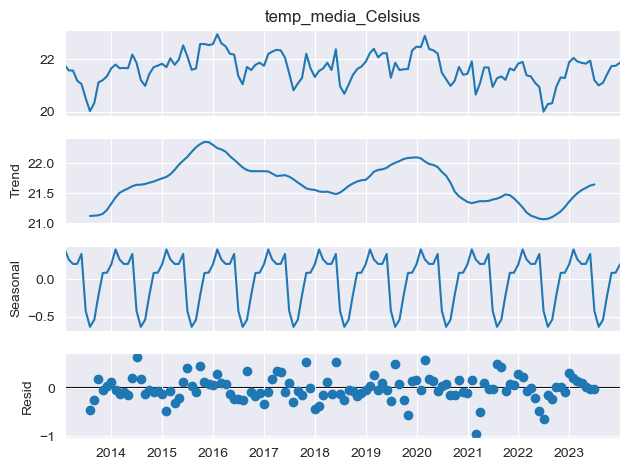

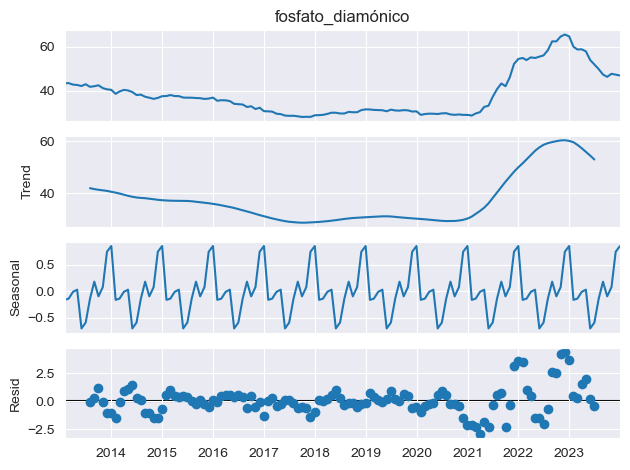

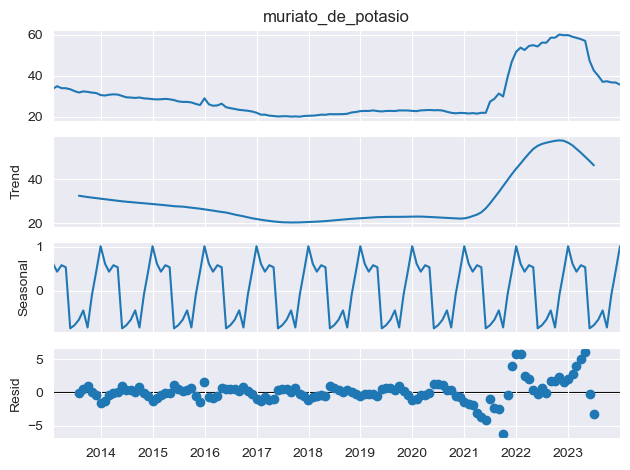

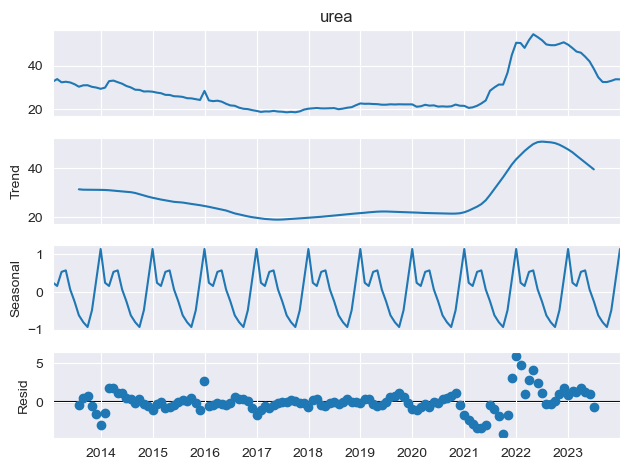

In [65]:
from statsmodels.tsa.seasonal import seasonal_decompose

for col in df.columns:
    decomposition = seasonal_decompose(df[col], model='additive', period=12)
    decomposition.plot()

In [66]:
import pmdarima as pm
from pmdarima.arima.utils import ndiffs, nsdiffs

diffs_dict = {}

for col in df.columns:
    # Determinar el número de diferenciaciones no estacionales
    d = ndiffs(df[col])

    # Determinar el número de diferenciaciones estacionales
    D = nsdiffs(df[col], m=12)
    
    # Almacenar valores de diferenciación:
    diffs_dict[col] = {
        'D' : D,
        'd' : d
        }

diffs_dict

{'precio_crudo_brent_usd_barril': {'D': 0, 'd': 0},
 'gas_natural_europa_usd_mmbtu': {'D': 0, 'd': 1},
 'inflación_mensual': {'D': 0, 'd': 0},
 'diesel': {'D': 0, 'd': 1},
 'gasolina_ecológica': {'D': 0, 'd': 1},
 'gasolina_bajo_octanaje': {'D': 0, 'd': 1},
 'gasolina_alto_octanaje': {'D': 0, 'd': 1},
 'precipitación_media_mm': {'D': 0, 'd': 0},
 'temp_media_Celsius': {'D': 0, 'd': 0},
 'fosfato_diamónico': {'D': 0, 'd': 1},
 'muriato_de_potasio': {'D': 0, 'd': 1},
 'urea': {'D': 0, 'd': 1}}

### Limpieza de series de tiempo

In [67]:
def percent_change(values):
    """
    Calcula el porcentaje de cambio entre el último valor y la media de los valores previos
    """
    previous_values = values[:-1]
    last_value = values[-1]
    pct_change = (last_value - np.mean(previous_values))\
        / np.mean(previous_values)
    return pct_change

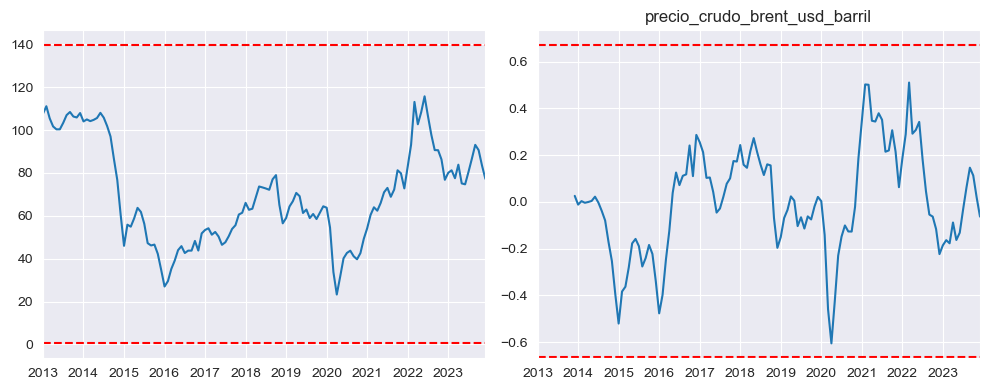

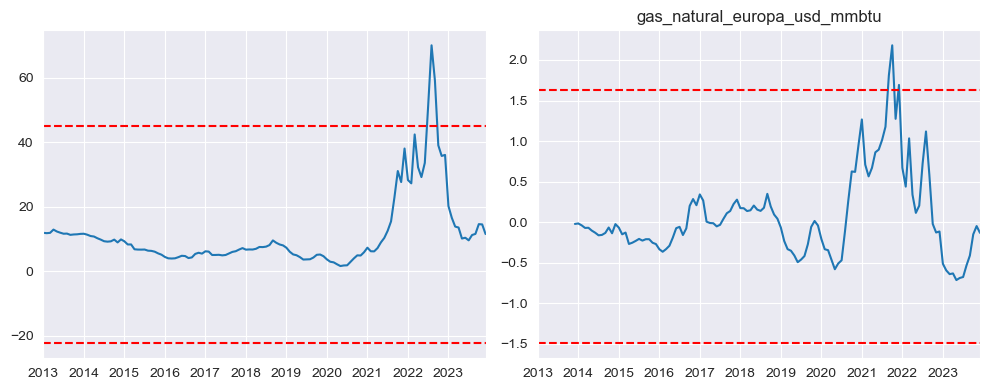

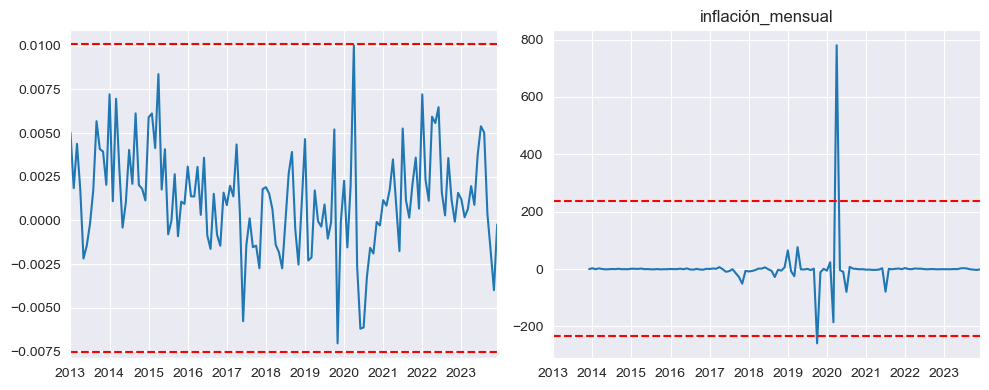

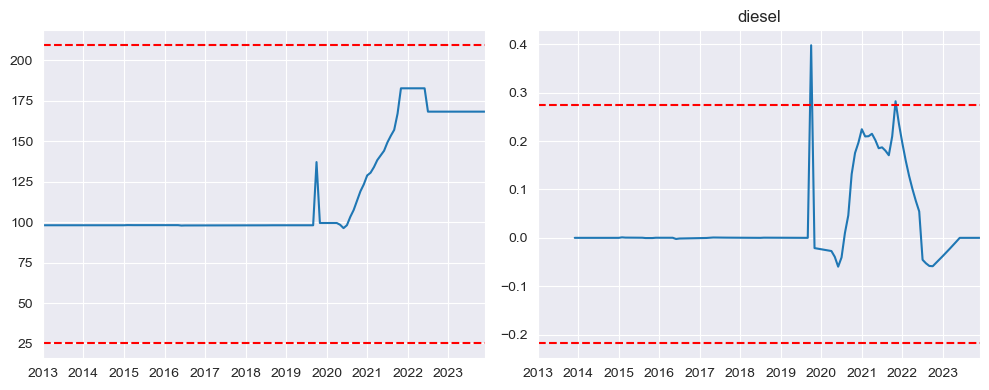

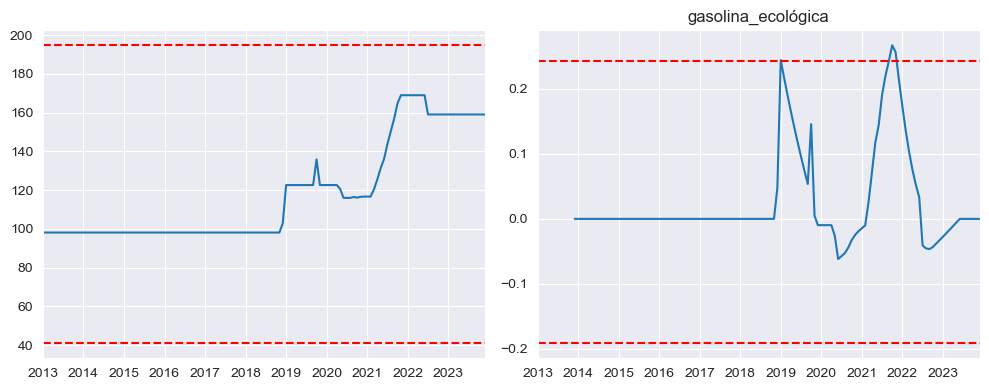

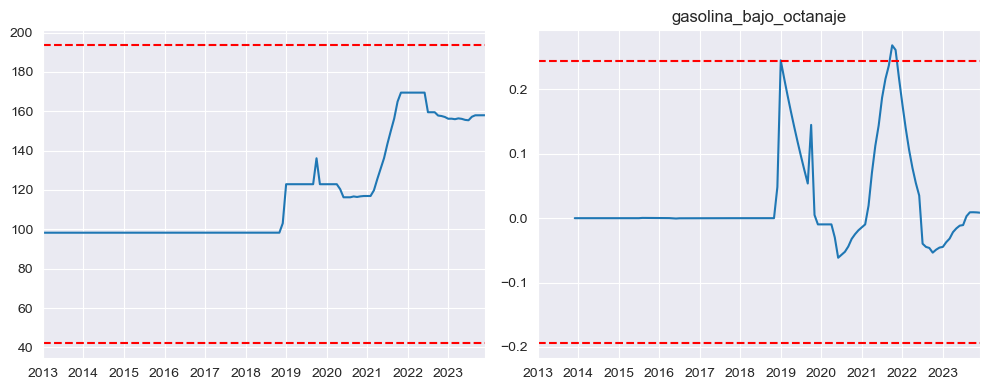

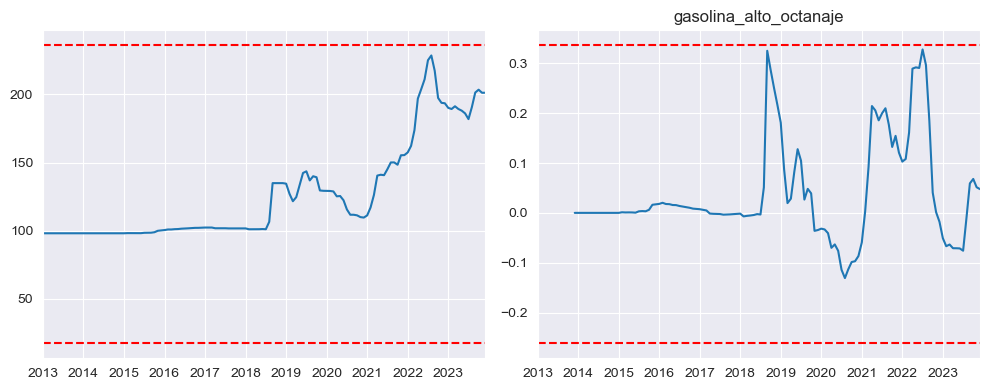

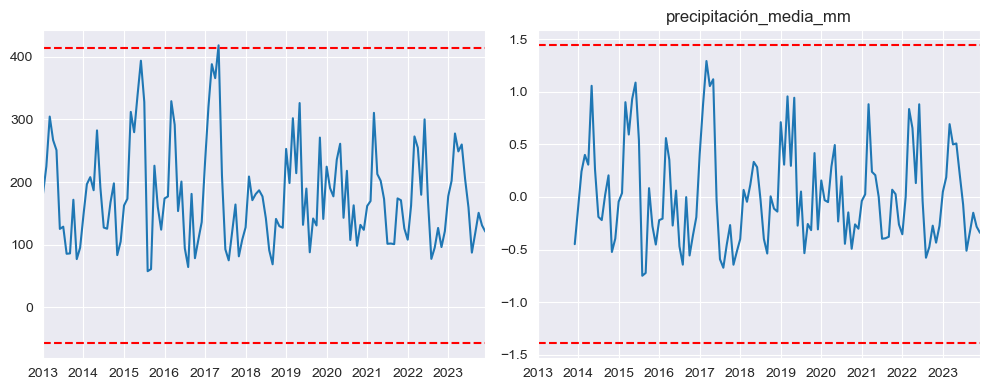

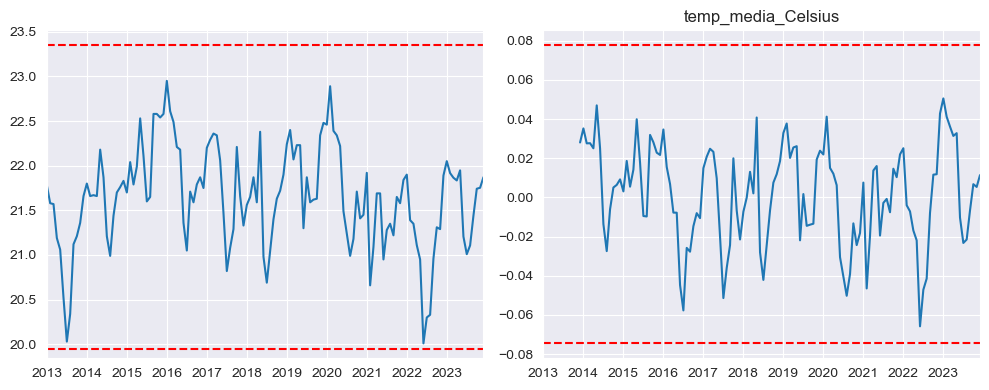

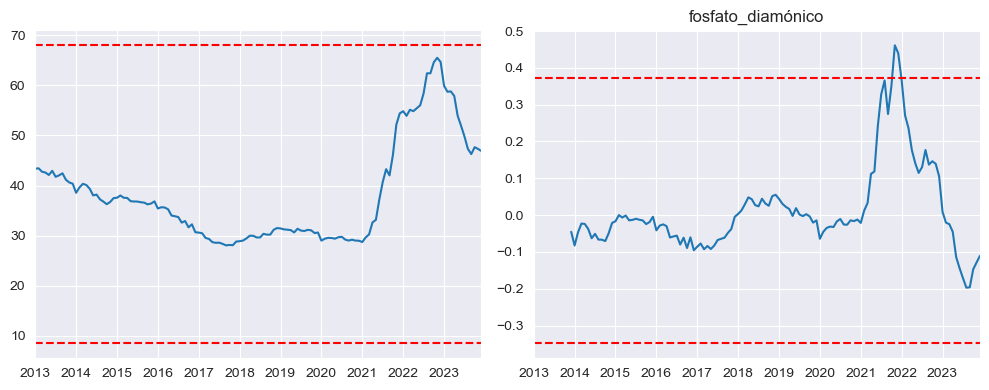

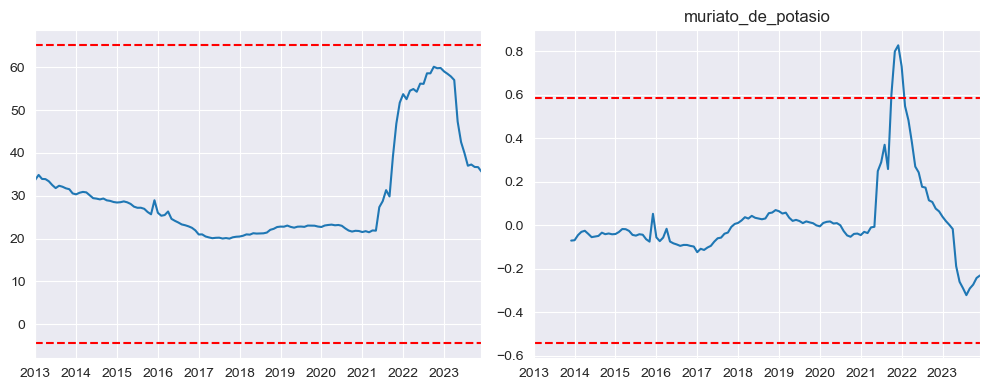

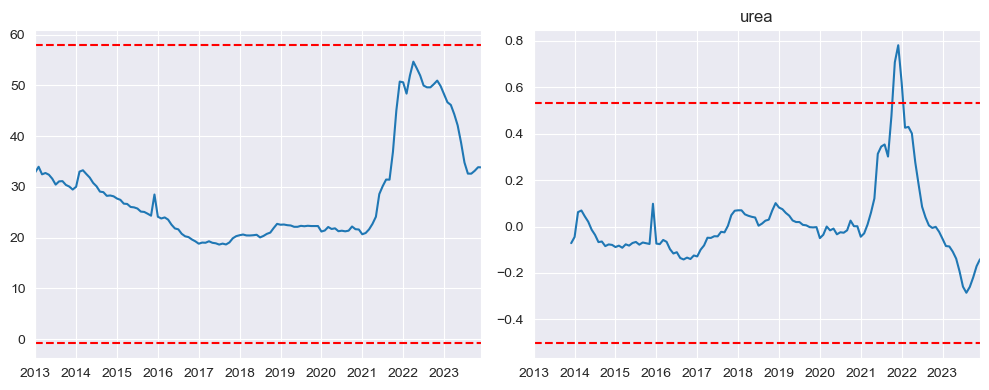

In [68]:
cambio_porcentual_precios = df.copy()

for col in cambio_porcentual_precios.columns:
    cambio_porcentual_precios[col] = cambio_porcentual_precios[col]\
        .rolling(window=12)\
        .aggregate(percent_change)
        
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    
    # Iteramos sobre ambas series de tiempo:
    for data, ax in zip([df[col], cambio_porcentual_precios[col]], axs):
        
        # Calculamos media y desviación estándar:
        mean = data.mean()
        std = data.std()
        
        # Graficamos los datos con un marcador de 3 desviaciones estándar:
        data.plot(ax=ax)
        ax.axhline(mean + std * 3, ls="--", c="r")
        ax.axhline(mean - std * 3, ls="--", c="r")
        
    plt.title(col)
    plt.tight_layout()    
    plt.show()

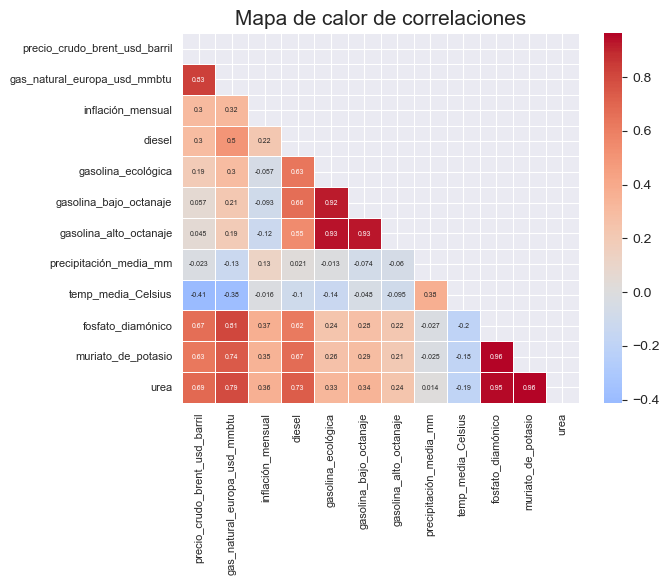

In [69]:
# Graficar mapa de calor de correlaciones no lineales:
corr = df.corr(method="spearman")
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(data=corr, mask=mask, cmap='coolwarm', center=0, linewidths=0.5, annot=True, annot_kws={"size": 5})
plt.title('Mapa de calor de correlaciones', size=15)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.show()

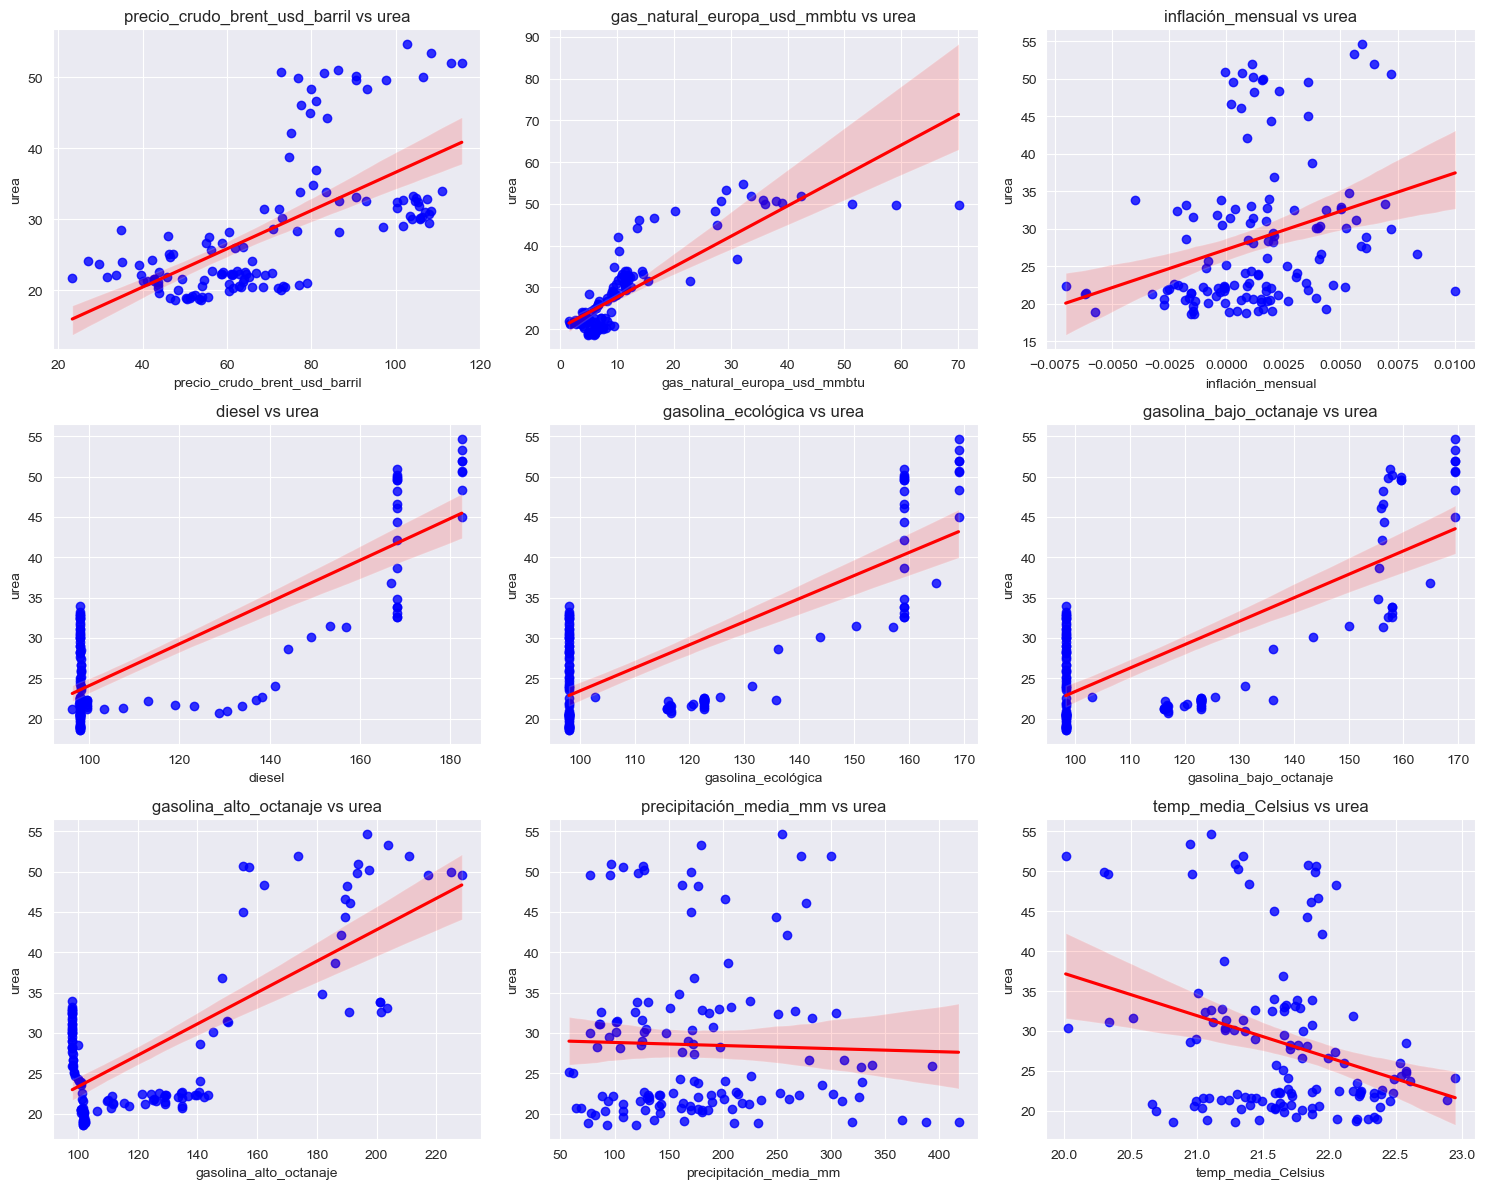

In [70]:
Y_list = ['fosfato_diamónico', 'muriato_de_potasio', 'urea']
target_var= 'urea'

X = df.drop(columns=Y_list)
y = df[target_var]

# Número de características en X
num_features = X.shape[1]

# Determinar el número de filas y columnas para la cuadrícula
num_rows = int(np.ceil(np.sqrt(num_features)))
num_cols = int(np.ceil(num_features / num_rows))

# Crear una cuadrícula de subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(5*num_cols, 4*num_rows))

# Si solo hay una característica, axes no es una lista, así que lo convertimos en una lista para la iteración
if num_features == 1:
    axes = [axes]

# Aplanar la lista de ejes para facilitar la iteración
axes = np.array(axes).flatten()

# Iterar sobre cada característica y crear un diagrama de dispersión con línea de regresión
for i, col in enumerate(X.columns):
    sns.regplot(x=X[col], y=y, ax=axes[i], color='blue', line_kws={"color": "red"})
    
    axes[i].set_title(f'{col} vs {target_var}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel(target_var)

# Eliminar cualquier eje adicional que no se use
for j in range(num_features, num_rows*num_cols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

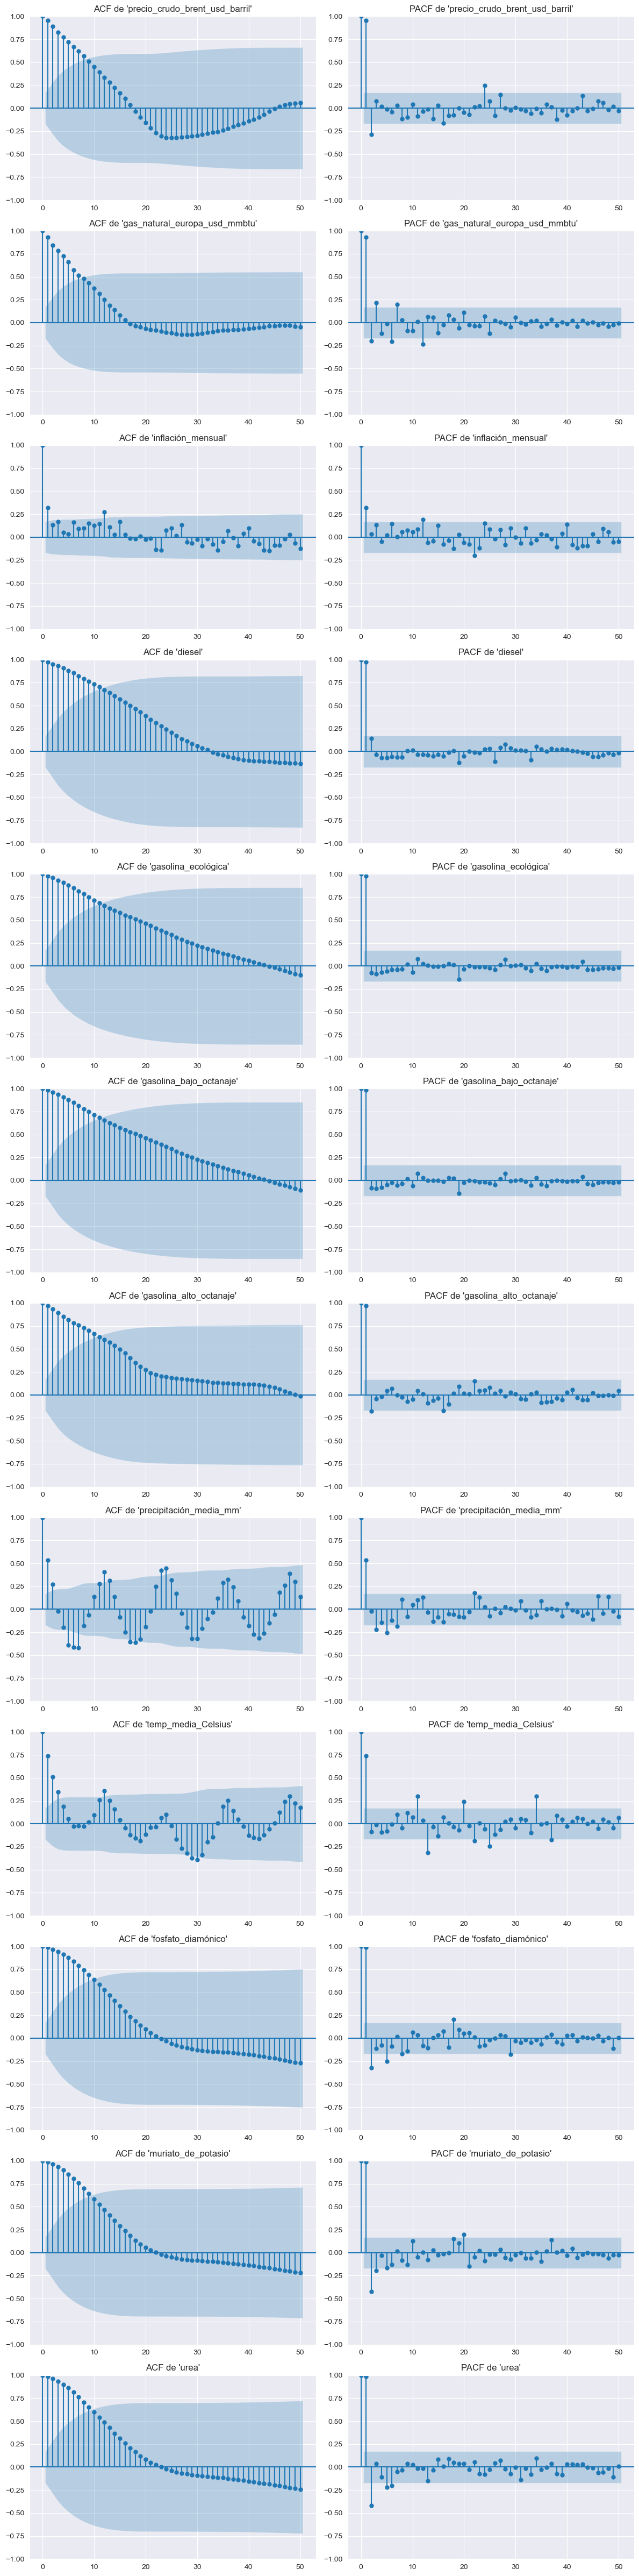

In [71]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Número de variables
n_vars = df.shape[1]

# Creamos una cuadrícula de subgráficos:
fig, axes = plt.subplots(nrows=n_vars, ncols=2, figsize=(12, 4 * n_vars))

for i, column in enumerate(df.columns):
    plot_acf(df[column], lags=50, alpha=0.05, ax=axes[i, 0], title=f"ACF de '{column}'")
    plot_pacf(df[column], lags=50, alpha=0.05, ax=axes[i, 1], title=f"PACF de '{column}'")

plt.tight_layout()
plt.show()

In [72]:
# Obtener las variables características regularizadas con una constante:
const_X = sm.add_constant(X)

# Ajustamos una regresión OLS robusta con HC1 para posibles valores atípicos:
model = sm.OLS(y, const_X).fit(cov_type='HC3')
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   urea   R-squared:                       0.888
Model:                            OLS   Adj. R-squared:                  0.880
Method:                 Least Squares   F-statistic:                     69.74
Date:                Tue, 23 Jan 2024   Prob (F-statistic):           7.46e-44
Time:                        11:18:35   Log-Likelihood:                -343.16
No. Observations:                 132   AIC:                             706.3
Df Residuals:                     122   BIC:                             735.1
Df Model:                           9                                         
Covariance Type:                  HC3                                         
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         